In [15]:
%matplotlib inline

Example of processing steps to create trial-unique beta maps from the CIMAQ fMRI data 
(memory task: image encoding), illustrated within a single subject:

The outputed beta maps are meant to be fed as features to a within-subject nilearn classifier.

Input:
    - task (event) files generated from raw eprime (.txt) outputs and organized into .tsv file 
    by cimaq_convert_eprime_to_bids_event.py script
    - confound (motion, etc) files generated from Niak preprocessing
    pipeline (confounds.tsv) 
    - preprocessed Niak data (4D .nii file found under resample; note: data are not smoothed)
Output: one map (3D .nii file) of beta (regression) weights for each trial, and one 
concatenated 4D file of these 3D maps (trials ordered chronologically).

Note: comparing two different ways to model trials of no interest
version 1: a separate model is built for each trial, with the trial of interest modelled as a separate condition (1 regressor), and all the other trials modelled in either the Encoding or Control condition (2 regressors)
**Update: betas from version 1 lead to much better enc/ctl trial classification**
version 2: a separate model is built for each trial, with the trial of interest modelled as a separate condition (1 regressor), and all the other trials modelled as a single "other" condition (1 regressor)
**Update: betas from version2 lead to poorer enc/ctl trial classification**

Reference: how to derive beta maps for MVPA classification (Mumford et al., 2012):
https://www.sciencedirect.com/science/article/pii/S1053811911010081

Also creating contrasts per condition (to derive features for between-subject classification): 
- a model that models enconding and control conditions across trials 
(3 beta maps: encoding (enc) , control (ctl), and encoding minus control (enc_minus_ctl)
- a model that models the control condition, as well as the encoding condition according to task performance : miss and hit (post-scan image recognition performance)
(5 beta maps: miss (miss), hit (hit), hit minus miss (hit_minus_miss), hit minus control
(hit_minus_ctl), miss minus control (miss_minus_ctl)
- a model that models the control condition, as well as the encoding condition according to task performance : miss, wrong source, and correct source.
(7 beta maps: wrong source (wrong_source), correct source (corr_source), correct source minus wrong source (cs_minus_ws), correct source minus miss (cs_minus_miss), wrong source minus miss (ws_minus_miss), correct source minus control (cs_minus_ctl), and wrong source minus control (ws_minus_ctl)


In [16]:
import glob
import nibabel
import nilearn
import numpy as np
import os
import pandas as pd
import scipy
import sys

from matplotlib import pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from numpy import nan as NaN
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join
from cimaq_utils import loadimages
from get_new_events import get_new_events
# from cimaq_utils import get_new_events

# import get_new_events
# from cimaq_getbetas import cimaq_getbetas
from pandas import DataFrame as df

#libraries need to be installed in conda environment with pip install

Step 1: Load confound parameters outputed from the NIAK preprocessing pipeline (slow signal drift, motion parameters, mean white matter and mean ventricle signal intensity)

**Note: The full NIAK preprocessing pipeline scrubs (regresses out) motion outlier frames, which may not be compatible with other software like Nilearn or Nistats.
Intermediate data from the preprocessing pipeline should be used that have been slice-timed, co-registered and resampled (motion-corrected).  

These data are found under the **resample** directory (not under fMRI), in .nii format, with accompanying _extra.mat and confounds.tsv.gz files. 
These data have undergone **no smoothing**, and confounds have NOT been regressed out. 

Use gunzip *gz command to unzip .tsv files inside working directory

**Update: the nistats first-level model can model some of the slow drift and noise parameters (not used here). Here, I use all the confounds in *counfounds.tsv (including slow drift) as regressors, so I don't model slow drift, etc in the first-level model (it's redundant). 


### Issue: There are no files ending with "extra.mat" in the directory
#### Searched recursively with loadimages()

In [17]:
maindir = xpu("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory")
# df([(bname(item), item) for item in loadimages(maindir)
#            if item.endswith(".nii") or item.endswith(".nii.gz")], columns=["item", "path"])
df([(bname(item), item) for item in loadimages(maindir)
           if item.endswith("extra.mat")], columns=["item", "path"])

Empty DataFrame
Columns: [item, path]
Index: []

In [18]:
#specify subject DCCID (6-digit identifier, in Loris-cimaq)
id = '122922' #this subject has 310 frames, few scrubbed frames, good data, and
# good balance of missed (23 trials), wrong source (30 trials) and correct source (25 trials)
#id = '763590' #this subject has 288 frames

#specify path to directory with *confound.tsv file
motion_dir = os.path.expanduser("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/confounds/resample")
resample_dir = os.path.expanduser("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/fmri/resample")

# subject_motion = glob.glob(os.path.join(motion_dir, 'fmri_sub'+id+'*confounds.tsv'))[0]
subject_motion = [(bname(file).split("fmri_sub")[1][:5], 
                   pd.read_csv(join(motion_dir, file), sep='\t').set_index("motion_tx"))
                  for file in ls(motion_dir)
                 if "fmri_sub" in bname(file) and file.endswith(".tsv")]

display(subject_motion)

[('97424',
             motion_ty  motion_tz  motion_rx  motion_ry  motion_rz        FD  \
  motion_tx                                                                    
  -0.008808  -0.061121  -0.302232   0.087028   0.054737  -0.130413  0.220996   
  -0.022110   0.002960  -0.214533   0.071559   0.030136  -0.106411  0.312559   
  -0.045521  -0.051180  -0.344704   0.186207   0.029185  -0.110948  0.240474   
  -0.029640   0.016360  -0.282653   0.103709   0.032439  -0.087836  0.185189   
  -0.037465  -0.035152  -0.342314   0.176768   0.032336  -0.085150  0.268189   
  ...              ...        ...        ...        ...        ...       ...   
   0.176156  -0.026772   0.077044   0.045435   0.068649  -0.148786  0.250586   
   0.174848   0.052428   0.159153  -0.045692   0.061693  -0.151507  0.043841   
   0.166545   0.052386   0.167668  -0.043131   0.046136  -0.164308  0.165589   
   0.166191   0.021523   0.138168   0.044279   0.066931  -0.176277  0.220481   
   0.168835   0.041183   0.24

In [19]:
# ##Not used in most current model##
# #create "short" counfounds dataframe with only a subset of confounds
# #these counfounds are to be used if slow drift, etc is modelled in nistats rather than niak
# short_counfounds = confounds.copy(deep = True)

# #select which columsn from NIAK counfounds.tsv file to include in first-level Nistats model 
# #(when modelling slow-drift and other junk parameters within Nistats instead of NIAK)
# colsKeep = ['motion_tx', 'motion_ty', 'motion_tz', 'motion_rx', 
#             'motion_ry', 'motion_rz', 'scrub', 'wm_avg', 'vent_avg']

# cols = confounds.columns

# #remove columns not in list of colums to keep (colsKeep)
# for i in cols:
#     if (i in colsKeep)==False:
#         short_counfounds.drop([i], axis=1, inplace=True)    

Step 2: create events variable, and events.tsv file from the 'sub-*_ses-4_task-memory_events.tsv' task file outputed by the cimaq_convert_eprime_to_bids_event.py script 

Number of rows = number of trials (the first-level model will use onset times to match conditions (trials) with fMRI frames).

Documentation:
https://nistats.github.io/auto_examples/04_low_level_functions/write_events_file.html#sphx-glr-auto-examples-04-low-level-functions-write-events-file-py

Each encoding trial is modelled as a different condition (under trial_type column) so that it is modelled separately when creating the design matrix. The trial has its own column in the design matrix; the other columns = other trials (modelled together as single regressor), and confound regressors.

**Note: Some scans were cut short, meaning that the last few trials do not have associated brain activation frames, and they need to be left out of the analysis; 310 frames = full scan, 288 frames = incomplete (~15 participants).
"unscanned" trials need to be excluded from the model (about ~2-4 trials missing).
288*2.5 = 720s. 
Trial #115 (out of 117) offset time ~ 710s
Trial #116 (out of 117) onset ~ 723s

In [25]:
# taskfilesdir = os.path.expanduser("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/task_files/processed")

# outTask_dir = os.path.expanduser("~/cimaq_memory/NEW_task_files")

# def get_new_events(taskfilesdir, outTask_dir):
#     #rename "trial_type" column as "condition"
#     taskfiles = [(os.path.splitext(bname(file))[0], pd.read_csv(join(taskfilesdir, file), sep='\t'))
#                  for file in ls(taskfilesdir) if "events" in file and file.endswith(".tsv")]
#     new_events = []

#     for s_task in taskfiles:
#         #load counfounds file as pandas dataframe 
#         confounds = pd.read_csv(subject_motion, sep='\t')
#         #scan duration, in seconds : number of fMRI frames (~310), times TR = 2.5s
#         scanDur = confounds.shape[0]*2.5
#         scanDur = s_task[1].shape[0]*2.5

#         s_task[1].rename(columns={'trial_type':'condition'}, inplace=True)

#         #add columns to DataFrame
#         numCol = s_task[1].shape[1] 
#         insertCol = [4, numCol+1, numCol+2, numCol+3]
#         colNames = ['trial_type', 'unscanned', 'ctl_miss_hit', 'ctl_miss_ws_cs']
#         colVals = ['TBD', 0, 'TBD', 'TBD']
#         for i in range(0, len(colNames)):
#             s_task[1].insert(loc=insertCol[i], column=colNames[i], value=colVals[i], allow_duplicates=True)

#         #The 'unscanned' column flag trials for which no brain data was acquired.
#         #The scan's duration is shorter than the trial's offset time
#         #(0 = data, 1 = no data)
#         for j in s_task[1][s_task[1]['offset']>scanDur].index:
#             s_task[1].loc[j, 'unscanned']=1

#         #pas trial numbers with zeros (on the left) to preserve trial 
#         #temporal order when trials are alphabetized
#         s_task[1]['trial_number'] = s_task[1]['trial_number'].astype('object',
#                                                                copy=False)
#         for k in s_task[1].index:
#             s_task[1].loc[k, 'trial_number'] = str(s_task[1].loc[k, 'trial_number']).zfill(3)

#         #trial_type should have a unique entry per row so that each trial 
#         #can be modelled as a separate condition
#         countEnc = 0
#         countCTL = 0
#         for m in s_task[1][s_task[1]['condition']=='Enc'].index:
#             countEnc = countEnc + 1
#             s_task[1].loc[m, 'trial_type'] = 'Enc'+str(countEnc)
#             if s_task[1].loc[m, 'position_accuracy'] == 0:
#                 s_task[1].loc[m, 'ctl_miss_hit']='missed'
#                 s_task[1].loc[m, 'ctl_miss_ws_cs']='missed'
#             elif s_task[1].loc[m, 'position_accuracy'] == 1:
#                 s_task[1].loc[m, 'ctl_miss_hit']='hit'
#                 s_task[1].loc[m, 'ctl_miss_ws_cs']='wrongsource'
#             elif s_task[1].loc[m, 'position_accuracy'] == 2:
#                 s_task[1].loc[m, 'ctl_miss_hit']='hit'
#                 s_task[1].loc[m, 'ctl_miss_ws_cs']='correctsource' 
#         for n in s_task[1][s_task[1]['condition']=='CTL'].index:
#             countCTL = countCTL + 1
#             s_task[1].loc[n, 'trial_type'] = 'CTL'+str(countCTL)
#             s_task[1].loc[n, 'ctl_miss_hit']='control'
#             s_task[1].loc[n, 'ctl_miss_ws_cs']='control'

#         #78 encoding and 39 control trials if full scan
#         print('Number of encoding trials:  ', countEnc)
#         print('Number of control trials:  ', countCTL)

#         #Export Dataframe to events.tsv file    
#         s_task[1].to_csv(outTask_dir+'/sub-'+id+'_events.tsv',
#                       sep='\t', header=True, index=False)

#         #keep only trials for which fMRI data was collected
# # #        s_task[1] = s_task[1][s_task[1]['unscanned']==0]

#         s_task[1]['unscanned'] = 0
    
#         #Save vectors of trial labels (e.g., encoding vs control)
#         #to label trials for classification analyses
#         ttypes1 = s_task[1]['condition']
#         ttypes1.to_csv(outTask_dir+'/sub-'+id+'_enco_ctl.tsv',
#                        sep='\t', header=True, index=False)

#         ttypes2 = s_task[1]['ctl_miss_hit']
#         ttypes2.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_hit.tsv',
#                        sep='\t', header=True, index=False)

#         ttypes3 = s_task[1]['ctl_miss_ws_cs']
#         ttypes3.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_ws_cs.tsv',
#                        sep='\t', header=True, index=False)

#         new_events.append([(s_task[0], s_task[1]), ttypes1, ttypes2, ttypes3])
#     #from s_task[1] dataframe, create an events dataframe to create a design matrix 
#     #that will be inputed into a first-level model in nistats
#     ev_cols = ['onset', 'duration', 'trial_type', 'condition', 'ctl_miss_hit', 
#                'ctl_miss_ws_cs', 'trial_number']
#     all_events = s_task[1][ev_cols]
#     return new_events, all_events

# new_events, all_events = get_new_events(taskfilesdir, outTask_dir)
# # print(all_events.shape)
# # print(all_events.iloc[0:30, :])
# display(new_events, all_events)

ValueError: Invalid file path or buffer object type: <class 'list'>

### Script appears to work. Saved under get_new_events.py in this directory

In [22]:
# taskfilesdir = os.path.expanduser("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/task_files/processed")
# outTask_dir = os.path.expanduser("~/cimaq_memory/NEW_task_files")
# new_events, all_events = get_new_events(taskfilesdir, outTask_dir)
# # print(all_events.shape)
# # print(all_events.iloc[0:30, :])
# display(new_events)

newdir = xpu("~/cimaq_events2020")
new_events = [dict((folder, [sheet for sheet in loadimages(join(newdir, folder))])
              for folder in ls(newdir))]
display(new_events)

[{'sub-4118813': ['/home/fnadeau/cimaq_events2020/sub-4118813/sub-4118813_task-retrieval_events.tsv',
   '/home/fnadeau/cimaq_events2020/sub-4118813/sub-4118813_task-memory_events_output.tsv',
   '/home/fnadeau/cimaq_events2020/sub-4118813/sub-4118813_task-memory_events_onset.tsv'],
  'sub-8758136': [],
  'sub-6957814': ['/home/fnadeau/cimaq_events2020/sub-6957814/sub-6957814_task-retrieval_events.tsv',
   '/home/fnadeau/cimaq_events2020/sub-6957814/sub-6957814_task-memory_events_output.tsv',
   '/home/fnadeau/cimaq_events2020/sub-6957814/sub-6957814_task-memory_events_onset.tsv'],
  'sub-4669690': ['/home/fnadeau/cimaq_events2020/sub-4669690/sub-4669690_task-memory_events_onset.tsv',
   '/home/fnadeau/cimaq_events2020/sub-4669690/sub-4669690_task-retrieval_events.tsv',
   '/home/fnadeau/cimaq_events2020/sub-4669690/sub-4669690_task-memory_events_output.tsv'],
  'sub-5485738': ['/home/fnadeau/cimaq_events2020/sub-5485738/sub-5485738_task-memory_events_output.tsv',
   '/home/fnadeau/cim

In [9]:
# #specify path to directory with task files (eventually on Stark)
# task_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/TaskFiles/Processed'

# #specify output directory
# outTask_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'

# subject_task = glob.glob(os.path.join(task_dir, 'sub-'+id+'*tsv'))[0]

# #load subject's task data as pandas DataFrame 
# s_task = pd.read_csv(subject_task, sep='\t')

# #rename "trial_type" column as "condition"
# s_task.rename(columns={'trial_type':'condition'}, inplace=True)

# #add columns to DataFrame
# numCol = s_task.shape[1] 
# insertCol = [4, numCol+1, numCol+2, numCol+3]
# colNames = ['trial_type', 'unscanned', 'ctl_miss_hit', 'ctl_miss_ws_cs']
# colVals = ['TBD', 0, 'TBD', 'TBD']
# for i in range(0, len(colNames)):
#     s_task.insert(loc=insertCol[i], column=colNames[i], value=colVals[i], allow_duplicates=True)

# #The 'unscanned' column flag trials for which no brain data was acquired.
# #The scan's duration is shorter than the trial's offset time
# #(0 = data, 1 = no data)
# for j in s_task[s_task['offset']>scanDur].index:
#     s_task.loc[j, 'unscanned']=1

# #pas trial numbers with zeros (on the left) to preserve trial 
# #temporal order when trials are alphabetized
# s_task['trial_number'] = s_task['trial_number'].astype('object',
#                                                        copy=False)
# for k in s_task.index:
#     s_task.loc[k, 'trial_number'] = str(s_task.loc[k, 'trial_number']).zfill(3)

# #trial_type should have a unique entry per row so that each trial 
# #can be modelled as a separate condition
# countEnc = 0
# countCTL = 0
# for m in s_task[s_task['condition']=='Enc'].index:
#     countEnc = countEnc + 1
#     s_task.loc[m, 'trial_type'] = 'Enc'+str(countEnc)
#     if s_task.loc[m, 'position_accuracy'] == 0:
#         s_task.loc[m, 'ctl_miss_hit']='missed'
#         s_task.loc[m, 'ctl_miss_ws_cs']='missed'
#     elif s_task.loc[m, 'position_accuracy'] == 1:
#         s_task.loc[m, 'ctl_miss_hit']='hit'
#         s_task.loc[m, 'ctl_miss_ws_cs']='wrongsource'
#     elif s_task.loc[m, 'position_accuracy'] == 2:
#         s_task.loc[m, 'ctl_miss_hit']='hit'
#         s_task.loc[m, 'ctl_miss_ws_cs']='correctsource' 
# for n in s_task[s_task['condition']=='CTL'].index:
#     countCTL = countCTL + 1
#     s_task.loc[n, 'trial_type'] = 'CTL'+str(countCTL)
#     s_task.loc[n, 'ctl_miss_hit']='control'
#     s_task.loc[n, 'ctl_miss_ws_cs']='control'

# #78 encoding and 39 control trials if full scan
# print('Number of encoding trials:  ', countEnc)
# print('Number of control trials:  ', countCTL)

# #Export Dataframe to events.tsv file    
# s_task.to_csv(outTask_dir+'/sub-'+id+'_events.tsv',
#               sep='\t', header=True, index=False)
    
# #keep only trials for which fMRI data was collected
# s_task = s_task[s_task['unscanned']==0]

# #Save vectors of trial labels (e.g., encoding vs control)
# #to label trials for classification analyses
# ttypes1 = s_task['condition']
# ttypes1.to_csv(outTask_dir+'/sub-'+id+'_enco_ctl.tsv',
#               sep='\t', header=True, index=False)

# ttypes2 = s_task['ctl_miss_hit']
# ttypes2.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_hit.tsv',
#               sep='\t', header=True, index=False)

# ttypes3 = s_task['ctl_miss_ws_cs']
# ttypes3.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_ws_cs.tsv',
#               sep='\t', header=True, index=False)


# #from s_task dataframe, create an events dataframe to create a design matrix 
# #that will be inputed into a first-level model in nistats
# ev_cols = ['onset', 'duration', 'trial_type', 'condition', 'ctl_miss_hit', 
#            'ctl_miss_ws_cs', 'trial_number']
# all_events = s_task[ev_cols]  

# print(all_events.shape)
# print(all_events.iloc[0:30, :])


(117, 7)
      onset  duration trial_type condition ctl_miss_hit ctl_miss_ws_cs  \
0    25.027     3.009       Enc1       Enc          hit  correctsource   
1    28.537     3.009       CTL1       CTL      control        control   
2    32.048     3.009       Enc2       Enc          hit    wrongsource   
3    39.553     3.009       Enc3       Enc          hit    wrongsource   
4    44.552     3.009       CTL2       CTL      control        control   
5    51.054     3.009       CTL3       CTL      control        control   
6    55.551     3.009       Enc4       Enc       missed         missed   
7    61.051     3.009       Enc5       Enc          hit    wrongsource   
8    65.063     3.009       CTL4       CTL      control        control   
9    71.064     3.009       Enc6       Enc          hit  correctsource   
10   78.068     3.009       CTL5       CTL      control        control   
11   81.579     3.008       Enc7       Enc       missed         missed   
12   87.078     3.009       C

**Step3 : Implement first-level model (implements regression in nistats), generate contrasts and output maps of beta values (parameter estimators; one map of betas per trial).

**About first-level model:

Note 1: nistats.first_level_model provides an interface to use the glm implemented in nistats.regression

Note 2: each encoding trial is modelled as a separate condition to obtain separate maps of beta values (model's output type to get betas = **effect sizes** (Nistats name), aka parameter estimates)

**UPDATE: a separate model is created to obtain a beta map for each trial. 
The trial of interest is modelled as a unique condition (it has its own column in the design matrix), and the other trials are modelled together.
Version A: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled separately (2 regressors)
Version B: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled together as a single "other_trials" condition (1 regressor)

Note 3: the first_level_model can either be given a pre-constructed **design matrix** (built from the events and confounds files in a separate preparatory step) as a parameter, or be given the **events and confounds** files directly as parameters (skipping the need to create a design matrix in a separate step). In the second situation, the model will generate and output the design matrix.  

As a parameter to the first-level-model, the design matrix takes precedence over the events and confounds parameters.

Nistats link on design matrices:
https://nistats.github.io/auto_examples/04_low_level_functions/plot_design_matrix.html

https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html

Example where the design matrix is created directly within the first level model interface by inputing events and confounds files directly as parameters (I'm not doing that here): https://nistats.github.io/auto_examples/01_tutorials/plot_first_level_model_details.html#running-a-basic-model

CHOSEN: 2-step method. Create design matrix directly from events file and confounds outputed from NIAK (resample directory), then generate and fit first-level-model

**About contrasts and maps of beta values (parameter estimators):

When each trial is modeled as a separate condition, it is represented as its own column in the design matrix. 

To access the estimated coefficients (betas of the GLM model), we need to specify "canonical contrasts" (one per trial) that isolate design matrix columns (each contrast has a single 1 in its corresponding colum, and 0s for all the other columns).

Sources of info: how to extract beta maps in nistats (instructions are a bit obscure)
https://15-35545854-gh.circle-artifacts.com/0/home/ubuntu/nistats/doc/_build/html/auto_examples/plot_spm_auditory.html
https://github.com/poldracklab/fitlins/pull/48
https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel


**Version A: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials are modelled as two conditions: control, and encoding (excluding trial of interest)


In [135]:
#where save outputted beta maps
outBeta_dir_A = os.makedirs(xpu("~/getbetas_01"),
                           exist_ok=True)
# maindir = xpu("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/Data/")
newdir = xpu("~/cimaq_events2020")
confounds_dir = xpu("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/confounds/resample")

p1 = df((((bname(dname(sheet)), sheet)
                  for sheet in 
                  [sheet for sheet
                   in loadimages(newdir)
                   if "Memory" in sheet])),
               columns=['sub-ID', 'sheetpaths'] ).set_index('sub-ID')
conflist = df((((bname(dname(sheet)), sheet)
                  for sheet in 
                  [sheet for sheet
                   in loadimages(confounds_dir)])),
               columns=['sub-ID', 'sheetpaths'] ).set_index('sub-ID')
p1 = p1.drop([p1.loc[ind] for ind in p1.index if ind not in conflist.index], axis=0)
# p1['confpaths'] = conflist.values.flatten()
display(p1)


KeyError: "[('/home/fnadeau/cimaq_events2020/sub-4118813/sub-4118813_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8758136/sub-8758136_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6957814/sub-6957814_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4669690/sub-4669690_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5485738/sub-5485738_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3702154/sub-3702154_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3123186/sub-3123186_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4475292/sub-4475292_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8352112/sub-8352112_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3494204/sub-3494204_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5477234/sub-5477234_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5760364/sub-5760364_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4206804/sub-4206804_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7424803/sub-7424803_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6258913/sub-6258913_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8639515/sub-8639515_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6741996/sub-6741996_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8330218/sub-8330218_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4893763/sub-4893763_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4810652/sub-4810652_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4799805/sub-4799805_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4344061/sub-4344061_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7113680/sub-7113680_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5375537/sub-5375537_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7948407/sub-7948407_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7435733/sub-7435733_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5522727/sub-5522727_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4694616/sub-4694616_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4398745/sub-4398745_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4050235/sub-4050235_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3708747/sub-3708747_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5381177/sub-5381177_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6023087/sub-6023087_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6417837/sub-6417837_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-9494076/sub-9494076_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7661810/sub-7661810_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3750063/sub-3750063_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3025432/sub-3025432_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3874544/sub-3874544_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4557550/sub-4557550_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8060583/sub-8060583_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-9249304/sub-9249304_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8278658/sub-8278658_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7729270/sub-7729270_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5028259/sub-5028259_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5348754/sub-5348754_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4548020/sub-4548020_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3420680/sub-3420680_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8875385/sub-8875385_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4117134/sub-4117134_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7674650/sub-7674650_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5701721/sub-5701721_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8600790/sub-8600790_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6334263/sub-6334263_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3431566/sub-3431566_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4051959/sub-4051959_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6121388/sub-6121388_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7543023/sub-7543023_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8874623/sub-8874623_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7516889/sub-7516889_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-9296157/sub-9296157_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8069157/sub-8069157_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3801419/sub-3801419_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4576408/sub-4576408_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6633412/sub-6633412_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-9929164/sub-9929164_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7060373/sub-7060373_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4835330/sub-4835330_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8827943/sub-8827943_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7538204/sub-7538204_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6168985/sub-6168985_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4316663/sub-4316663_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7256003/sub-7256003_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6421082/sub-6421082_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3303819/sub-3303819_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7712552/sub-7712552_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6274286/sub-6274286_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3967609/sub-3967609_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6281721/sub-6281721_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3291977/sub-3291977_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7707569/sub-7707569_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3865361/sub-3865361_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3163875/sub-3163875_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7874568/sub-7874568_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3400972/sub-3400972_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8980899/sub-8980899_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8656527/sub-8656527_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6427603/sub-6427603_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-6841569/sub-6841569_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3970362/sub-3970362_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8192087/sub-8192087_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7459501/sub-7459501_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-5089797/sub-5089797_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4501657/sub-4501657_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3514091/sub-3514091_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-4509950/sub-4509950_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7086941/sub-7086941_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-9003010/sub-9003010_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-8212673/sub-8212673_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-3589314/sub-3589314_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7274924/sub-7274924_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7485585/sub-7485585_task-Memory_events.tsv',)\n ('/home/fnadeau/cimaq_events2020/sub-7308293/sub-7308293_task-Memory_events.tsv',)] not found in axis"

In [116]:
#117 trials if full scan (no missing frames)
numTrials = pd.read_csv(new_events[0], sep='\t').shape[0]

##
#This concatenation step might become obsolete, test Nilearn concatenation based on padded numbers!!
####
#Compile list of beta maps and their trial number, to be sorted by order of trial
all_betas_filelist_A = []
####

display(confoundslist)


[     motion_tx  motion_ty  motion_tz  motion_rx  motion_ry  motion_rz  \
 0    -0.008808  -0.061121  -0.302232   0.087028   0.054737  -0.130413   
 1    -0.022110   0.002960  -0.214533   0.071559   0.030136  -0.106411   
 2    -0.045521  -0.051180  -0.344704   0.186207   0.029185  -0.110948   
 3    -0.029640   0.016360  -0.282653   0.103709   0.032439  -0.087836   
 4    -0.037465  -0.035152  -0.342314   0.176768   0.032336  -0.085150   
 ..         ...        ...        ...        ...        ...        ...   
 305   0.176156  -0.026772   0.077044   0.045435   0.068649  -0.148786   
 306   0.174848   0.052428   0.159153  -0.045692   0.061693  -0.151507   
 307   0.166545   0.052386   0.167668  -0.043131   0.046136  -0.164308   
 308   0.166191   0.021523   0.138168   0.044279   0.066931  -0.176277   
 309   0.168835   0.041183   0.241726  -0.054839   0.071430  -0.171469   
 
            FD  scrub  slow_drift  slow_drift.1  ...  slow_drift.13  \
 0    0.220996      0    1.407391      

In [111]:
#Create a design matrix, first level model and beta map for each encoding and control trial 
for i in range (0, numTrials):
    #Define parameters related to image acquisition
    tr = 2.5 #repetition time in seconds
    n_scans = confoundslist[0].shape[0] #number of frames
    frame_times = np.arange(n_scans)*tr # corresponding frame times for each epi scan
    hrf_model = 'spm' #alternatives: 'glover', or 'spm + derivative'

    ##specify: path to preprocessed fMRI .nii file (gunzip it first!)
    fmri_dir = xpu("~/../../data/cisl/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/fmri/resample")
    fmri_imgNS = [img for img in loadimages(confounds_dir)
                  if img.endswith(".nii")]
    # Apply 8mm smoothing since using unsmoothed preprocessed data 
    # taken from NIAK's "resample" output directory
    fmri_img = [image.smooth_img(img, 8) for img in fmri_imgNS]

    confounds = confoundslist[i]
    #copy all_events dataframe to keep the original intact
#     events = df.from_dict(dict((bname(dname(event)),
#                   df(event).copy().values)
#                  for event in new_events), orient='index')
    

#     #Determine trial number and condition (encoding or control)
# #     tnum = events.iloc[i,: 6]
# #     currentCondi = events.[i,: 3]
# #     tname = events.iloc[i,: 2]
        
#     #Version A: (2 conditions modelled separately)
#     #modify trial_type column to model only the trial of interest 
# #     for ind in events.index:
# #         if events.loc[ind]['trial_number'] != tnum:
# #             events.loc[ind]['trial_type'] = 'X_'+ events.loc[ind]['condition']
#             #X for condition to remain in alphabetical order: trial of interest, X_CTL, X_Enc
#     #verify: what determines the order of columns in design matrix?    

#     #remove unecessary columns
# #     cols = ['onset', 'duration', 'trial_type']
# #     events = events[cols]
    
#     #create the model
#     trial_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
#                                hrf_model = hrf_model)    
#     #Should data be standardized?

#     #create the design matrix
#     design = make_first_level_design_matrix(frame_times, events=events,
#                                             drift_model=None, add_regs=confounds, 
#                                             hrf_model=hrf_model)

#     #fit model with design matrix
#     trial_model = trial_model.fit(fmri_img, design_matrices = design)
    
#     design_matrix = trial_model.design_matrices_[0]
    
#     #sanity check: print design matrices and corresponding parameter labels
#     #plot outputed design matrix for visualization
#     #print(str(tnum), ' ', tname, ' ', design_matrix.columns[0:3])
#     #plot_design_matrix(design_matrix)
#     #plt.show()

#     #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
#     contrast_vec = np.repeat(0, design_matrix.shape[1])
#     contrast_vec[0] = 1

#     #compute the contrast's beta maps with the model.compute_contrast() method,
#     #based on contrast provided. 
#     #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
#     b_map = trial_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
#     b_name = os.path.join(outBeta_dir_A, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
#     #export b_map .nii image in output directory
#     nibabel.save(b_map, b_name)
#     print(os.path.basename(b_name))
#     all_betas_filelist_A.append(b_name)
    
# alltrials_betas_A = nibabel.funcs.concat_images(images=all_betas_filelist_A, check_affines=True, axis=None)
# print(alltrials_betas_A.shape)
# nibabel.save(alltrials_betas_A, os.path.join(outBeta_dir_A, 'concat_all_betas_sub'+str(id)+'.nii'))
    

IndexError: list index out of range

**Version B: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials (encoding and control, excluding trial of interest) are modelled as a single condition

004   Enc1   Index(['Enc1', 'X_otherCondi', 'reg0'], dtype='object')


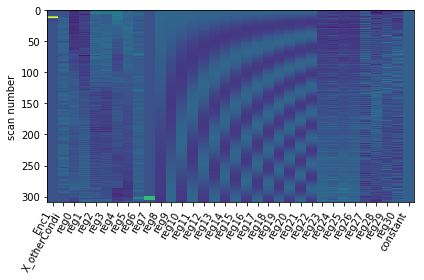

betas_sub122922_Trial004_Enc1.nii
005   CTL1   Index(['CTL1', 'X_otherCondi', 'reg0'], dtype='object')


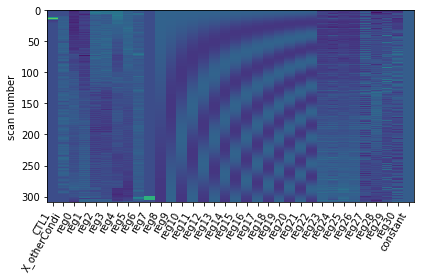

betas_sub122922_Trial005_CTL1.nii
006   Enc2   Index(['Enc2', 'X_otherCondi', 'reg0'], dtype='object')


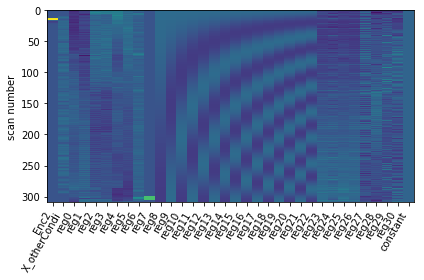

betas_sub122922_Trial006_Enc2.nii
007   Enc3   Index(['Enc3', 'X_otherCondi', 'reg0'], dtype='object')


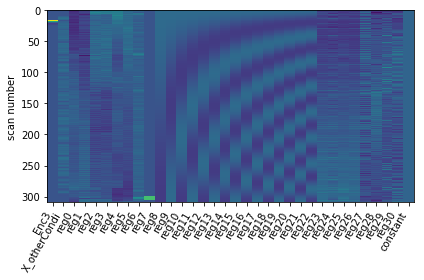

betas_sub122922_Trial007_Enc3.nii
008   CTL2   Index(['CTL2', 'X_otherCondi', 'reg0'], dtype='object')


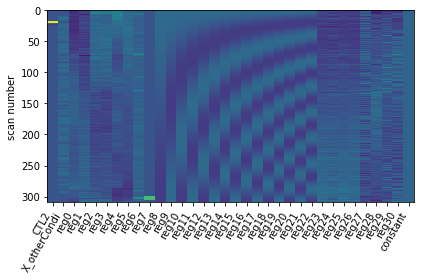

betas_sub122922_Trial008_CTL2.nii
009   CTL3   Index(['CTL3', 'X_otherCondi', 'reg0'], dtype='object')


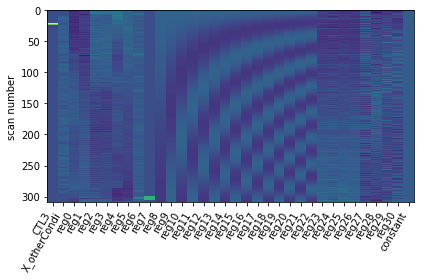

betas_sub122922_Trial009_CTL3.nii
010   Enc4   Index(['Enc4', 'X_otherCondi', 'reg0'], dtype='object')


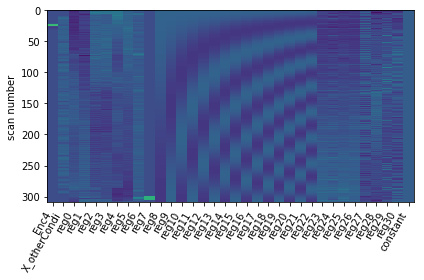

betas_sub122922_Trial010_Enc4.nii
011   Enc5   Index(['Enc5', 'X_otherCondi', 'reg0'], dtype='object')


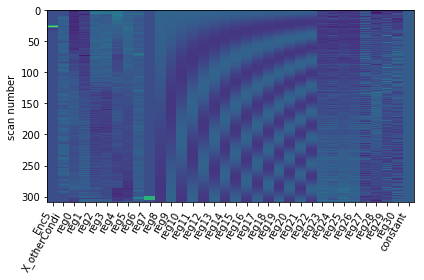

betas_sub122922_Trial011_Enc5.nii
012   CTL4   Index(['CTL4', 'X_otherCondi', 'reg0'], dtype='object')


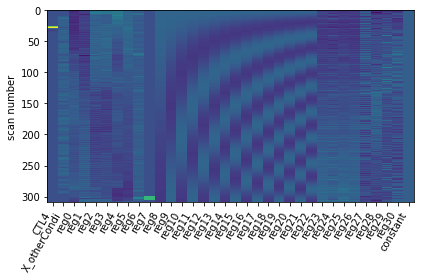

betas_sub122922_Trial012_CTL4.nii
013   Enc6   Index(['Enc6', 'X_otherCondi', 'reg0'], dtype='object')


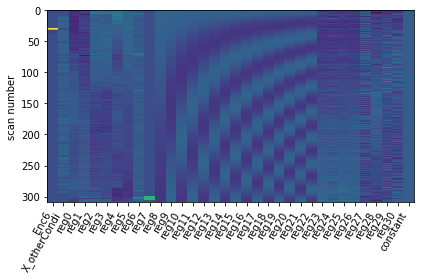

betas_sub122922_Trial013_Enc6.nii
014   CTL5   Index(['CTL5', 'X_otherCondi', 'reg0'], dtype='object')


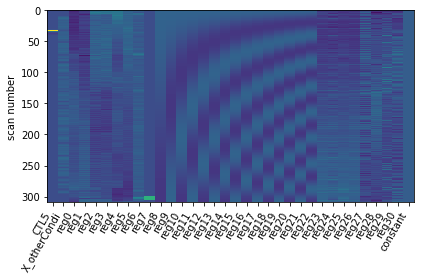

betas_sub122922_Trial014_CTL5.nii
015   Enc7   Index(['Enc7', 'X_otherCondi', 'reg0'], dtype='object')


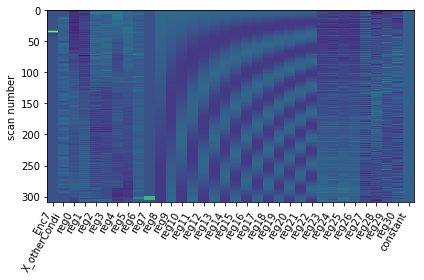

betas_sub122922_Trial015_Enc7.nii
016   CTL6   Index(['CTL6', 'X_otherCondi', 'reg0'], dtype='object')


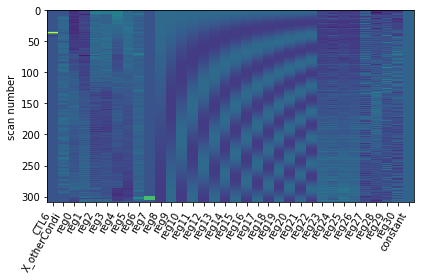

betas_sub122922_Trial016_CTL6.nii
017   CTL7   Index(['CTL7', 'X_otherCondi', 'reg0'], dtype='object')


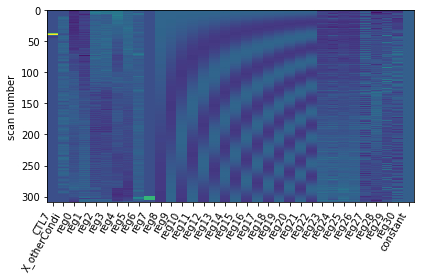

betas_sub122922_Trial017_CTL7.nii
018   Enc8   Index(['Enc8', 'X_otherCondi', 'reg0'], dtype='object')


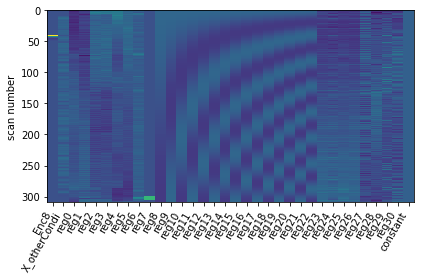

betas_sub122922_Trial018_Enc8.nii
019   Enc9   Index(['Enc9', 'X_otherCondi', 'reg0'], dtype='object')


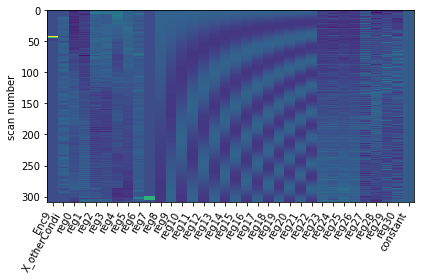

betas_sub122922_Trial019_Enc9.nii
020   Enc10   Index(['Enc10', 'X_otherCondi', 'reg0'], dtype='object')


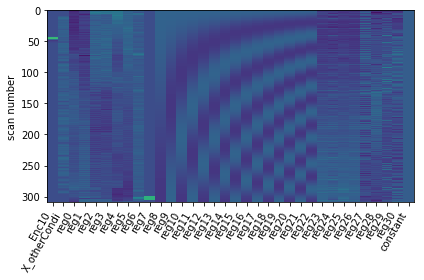

betas_sub122922_Trial020_Enc10.nii
021   Enc11   Index(['Enc11', 'X_otherCondi', 'reg0'], dtype='object')


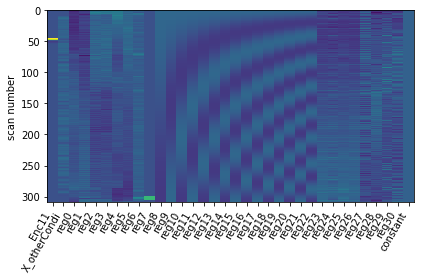

betas_sub122922_Trial021_Enc11.nii
022   Enc12   Index(['Enc12', 'X_otherCondi', 'reg0'], dtype='object')


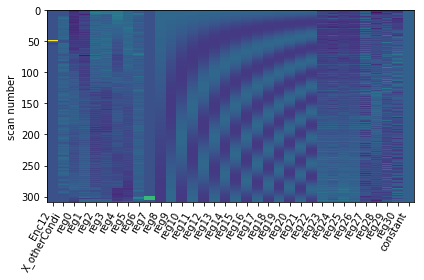

betas_sub122922_Trial022_Enc12.nii
023   Enc13   Index(['Enc13', 'X_otherCondi', 'reg0'], dtype='object')


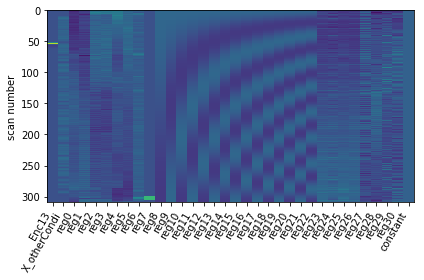

betas_sub122922_Trial023_Enc13.nii
024   Enc14   Index(['Enc14', 'X_otherCondi', 'reg0'], dtype='object')


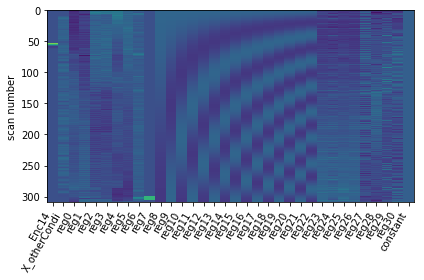

betas_sub122922_Trial024_Enc14.nii
025   Enc15   Index(['Enc15', 'X_otherCondi', 'reg0'], dtype='object')


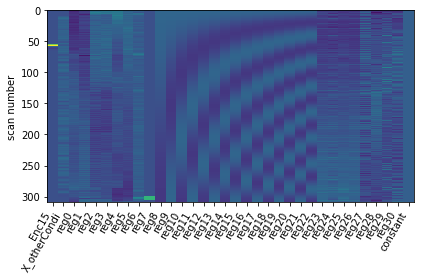

betas_sub122922_Trial025_Enc15.nii
026   Enc16   Index(['Enc16', 'X_otherCondi', 'reg0'], dtype='object')


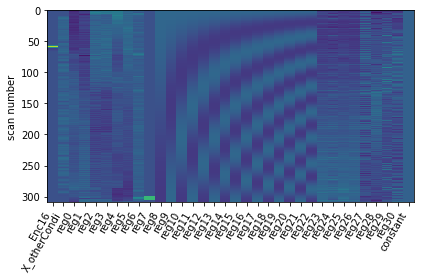

betas_sub122922_Trial026_Enc16.nii
027   Enc17   Index(['Enc17', 'X_otherCondi', 'reg0'], dtype='object')


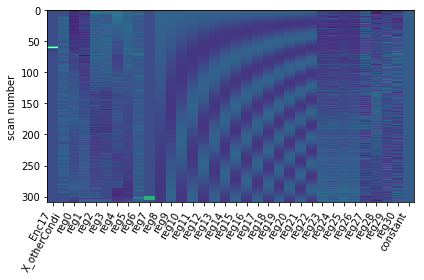

betas_sub122922_Trial027_Enc17.nii
028   CTL8   Index(['CTL8', 'X_otherCondi', 'reg0'], dtype='object')


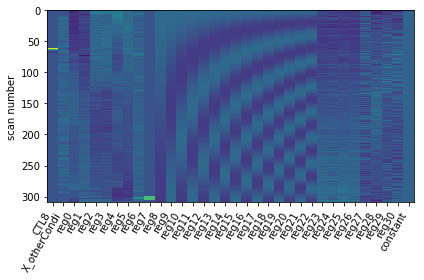

betas_sub122922_Trial028_CTL8.nii
029   Enc18   Index(['Enc18', 'X_otherCondi', 'reg0'], dtype='object')


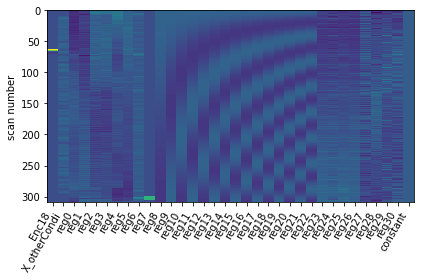

betas_sub122922_Trial029_Enc18.nii
030   Enc19   Index(['Enc19', 'X_otherCondi', 'reg0'], dtype='object')


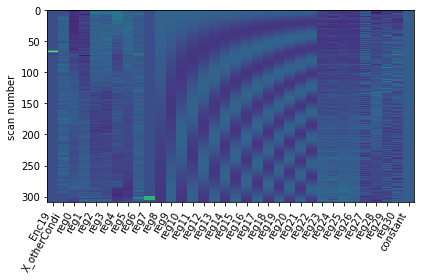

betas_sub122922_Trial030_Enc19.nii
031   Enc20   Index(['Enc20', 'X_otherCondi', 'reg0'], dtype='object')


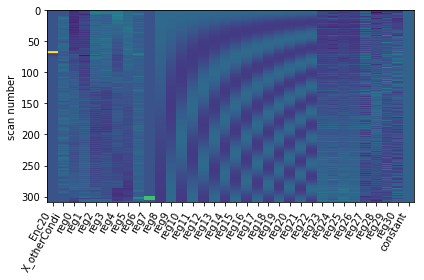

betas_sub122922_Trial031_Enc20.nii
032   CTL9   Index(['CTL9', 'X_otherCondi', 'reg0'], dtype='object')


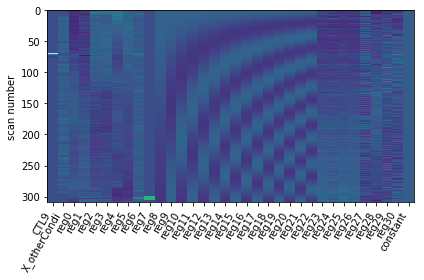

betas_sub122922_Trial032_CTL9.nii
033   Enc21   Index(['Enc21', 'X_otherCondi', 'reg0'], dtype='object')


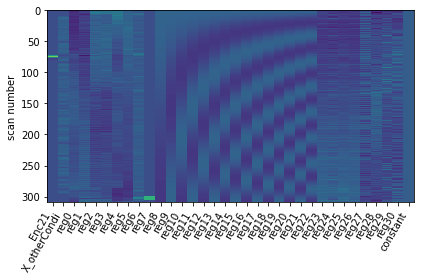

betas_sub122922_Trial033_Enc21.nii
034   Enc22   Index(['Enc22', 'X_otherCondi', 'reg0'], dtype='object')


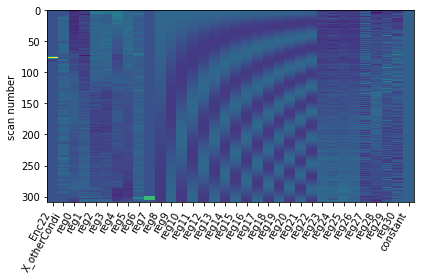

betas_sub122922_Trial034_Enc22.nii
035   Enc23   Index(['Enc23', 'X_otherCondi', 'reg0'], dtype='object')


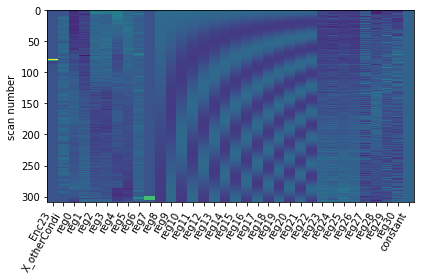

betas_sub122922_Trial035_Enc23.nii
036   Enc24   Index(['Enc24', 'X_otherCondi', 'reg0'], dtype='object')


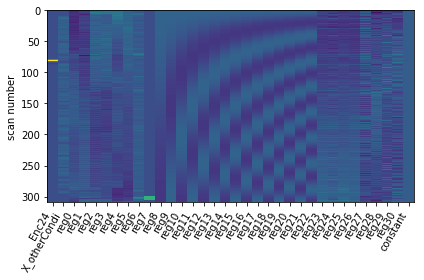

betas_sub122922_Trial036_Enc24.nii
037   Enc25   Index(['Enc25', 'X_otherCondi', 'reg0'], dtype='object')


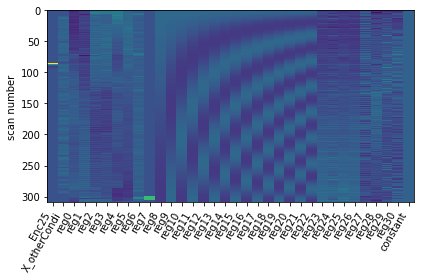

betas_sub122922_Trial037_Enc25.nii
038   Enc26   Index(['Enc26', 'X_otherCondi', 'reg0'], dtype='object')


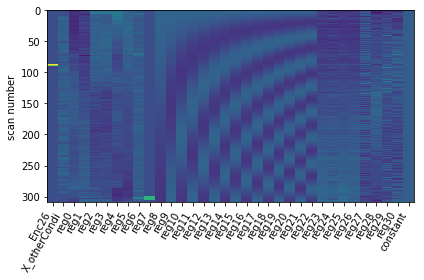

betas_sub122922_Trial038_Enc26.nii
039   Enc27   Index(['Enc27', 'X_otherCondi', 'reg0'], dtype='object')


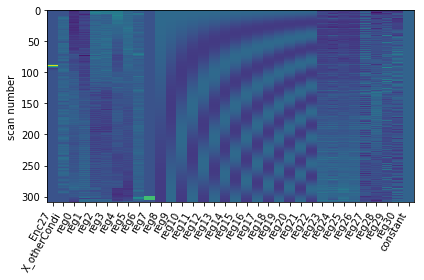

betas_sub122922_Trial039_Enc27.nii
040   Enc28   Index(['Enc28', 'X_otherCondi', 'reg0'], dtype='object')


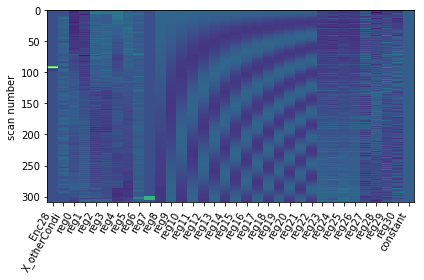

betas_sub122922_Trial040_Enc28.nii
041   CTL10   Index(['CTL10', 'X_otherCondi', 'reg0'], dtype='object')


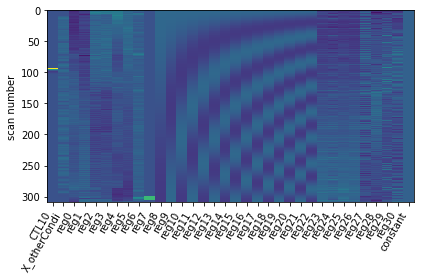

betas_sub122922_Trial041_CTL10.nii
042   CTL11   Index(['CTL11', 'X_otherCondi', 'reg0'], dtype='object')


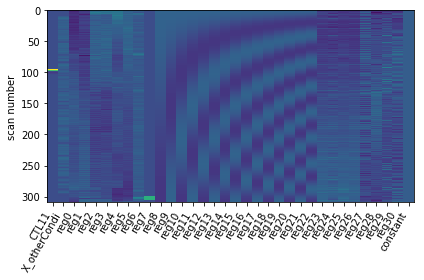

betas_sub122922_Trial042_CTL11.nii
043   CTL12   Index(['CTL12', 'X_otherCondi', 'reg0'], dtype='object')


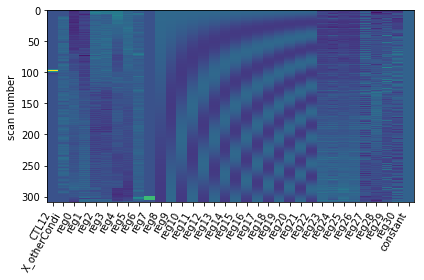

betas_sub122922_Trial043_CTL12.nii
044   CTL13   Index(['CTL13', 'X_otherCondi', 'reg0'], dtype='object')


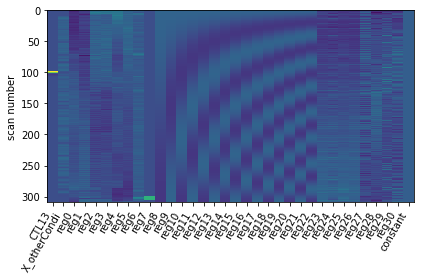

betas_sub122922_Trial044_CTL13.nii
045   Enc29   Index(['Enc29', 'X_otherCondi', 'reg0'], dtype='object')


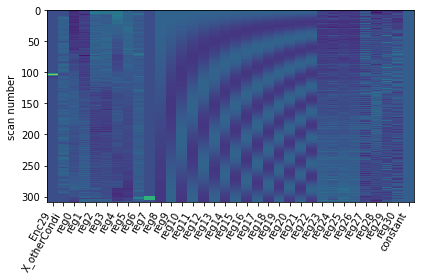

betas_sub122922_Trial045_Enc29.nii
046   Enc30   Index(['Enc30', 'X_otherCondi', 'reg0'], dtype='object')


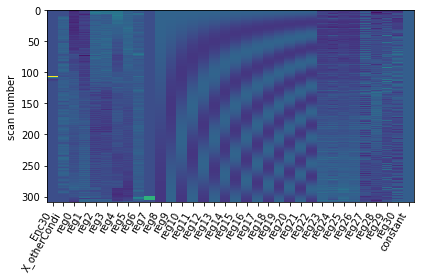

betas_sub122922_Trial046_Enc30.nii
047   CTL14   Index(['CTL14', 'X_otherCondi', 'reg0'], dtype='object')


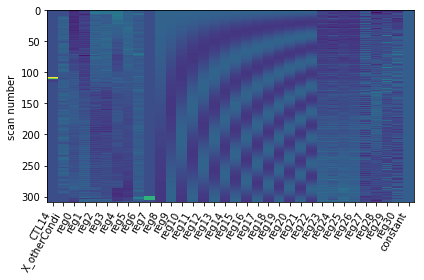

betas_sub122922_Trial047_CTL14.nii
048   Enc31   Index(['Enc31', 'X_otherCondi', 'reg0'], dtype='object')


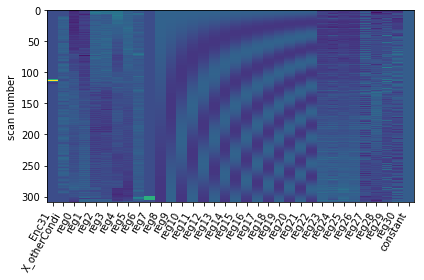

betas_sub122922_Trial048_Enc31.nii
049   Enc32   Index(['Enc32', 'X_otherCondi', 'reg0'], dtype='object')


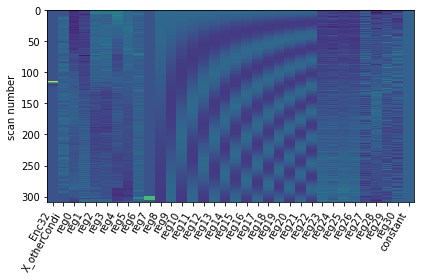

betas_sub122922_Trial049_Enc32.nii
050   Enc33   Index(['Enc33', 'X_otherCondi', 'reg0'], dtype='object')


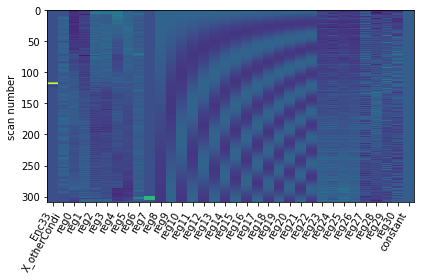

betas_sub122922_Trial050_Enc33.nii
051   Enc34   Index(['Enc34', 'X_otherCondi', 'reg0'], dtype='object')


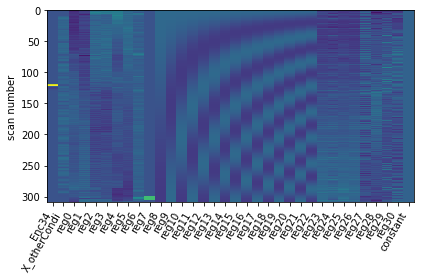

betas_sub122922_Trial051_Enc34.nii
052   CTL15   Index(['CTL15', 'X_otherCondi', 'reg0'], dtype='object')


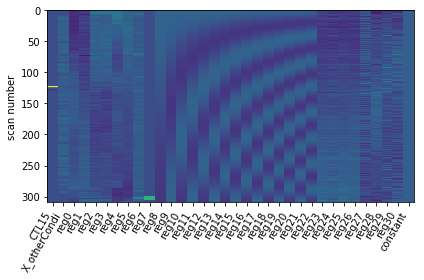

betas_sub122922_Trial052_CTL15.nii
053   Enc35   Index(['Enc35', 'X_otherCondi', 'reg0'], dtype='object')


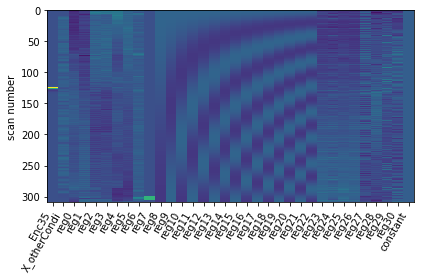

betas_sub122922_Trial053_Enc35.nii
054   CTL16   Index(['CTL16', 'X_otherCondi', 'reg0'], dtype='object')


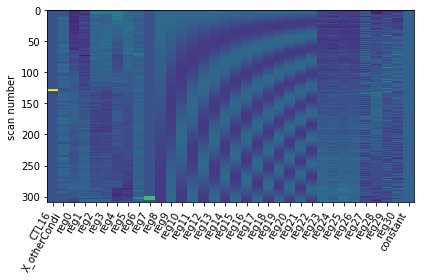

betas_sub122922_Trial054_CTL16.nii
055   CTL17   Index(['CTL17', 'X_otherCondi', 'reg0'], dtype='object')


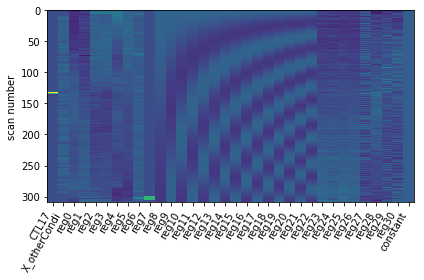

betas_sub122922_Trial055_CTL17.nii
056   Enc36   Index(['Enc36', 'X_otherCondi', 'reg0'], dtype='object')


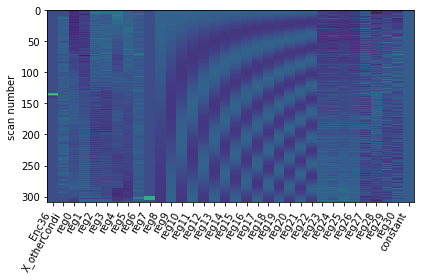

betas_sub122922_Trial056_Enc36.nii
057   Enc37   Index(['Enc37', 'X_otherCondi', 'reg0'], dtype='object')


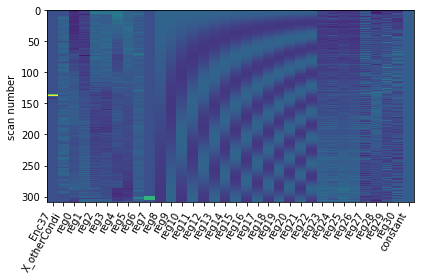

betas_sub122922_Trial057_Enc37.nii
058   Enc38   Index(['Enc38', 'X_otherCondi', 'reg0'], dtype='object')


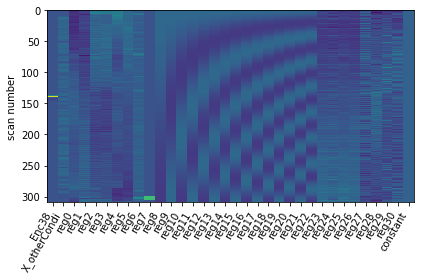

betas_sub122922_Trial058_Enc38.nii
059   CTL18   Index(['CTL18', 'X_otherCondi', 'reg0'], dtype='object')


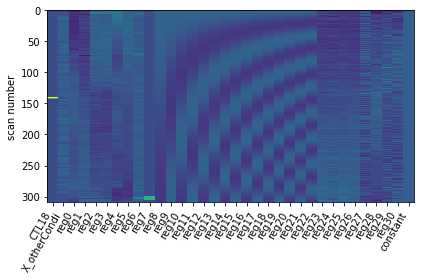

betas_sub122922_Trial059_CTL18.nii
060   Enc39   Index(['Enc39', 'X_otherCondi', 'reg0'], dtype='object')


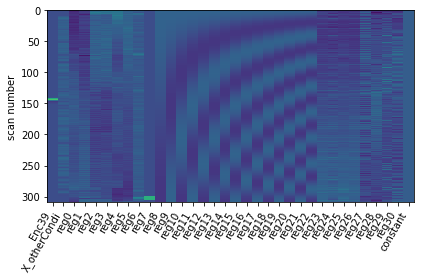

betas_sub122922_Trial060_Enc39.nii
061   Enc40   Index(['Enc40', 'X_otherCondi', 'reg0'], dtype='object')


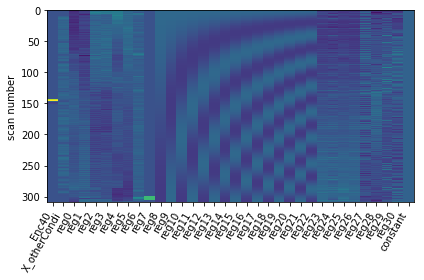

betas_sub122922_Trial061_Enc40.nii
062   Enc41   Index(['Enc41', 'X_otherCondi', 'reg0'], dtype='object')


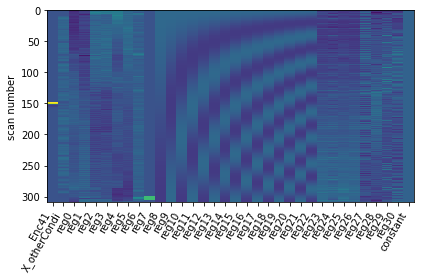

betas_sub122922_Trial062_Enc41.nii
063   Enc42   Index(['Enc42', 'X_otherCondi', 'reg0'], dtype='object')


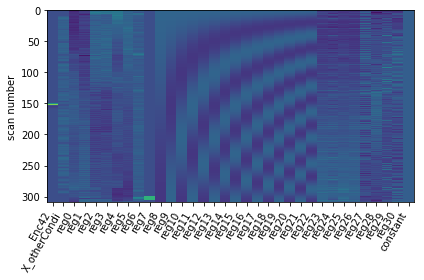

betas_sub122922_Trial063_Enc42.nii
064   Enc43   Index(['Enc43', 'X_otherCondi', 'reg0'], dtype='object')


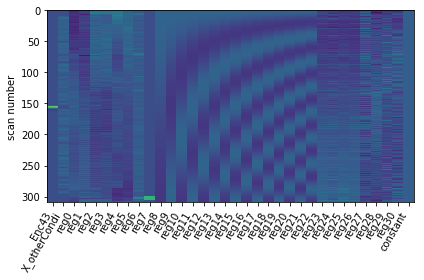

betas_sub122922_Trial064_Enc43.nii
065   CTL19   Index(['CTL19', 'X_otherCondi', 'reg0'], dtype='object')


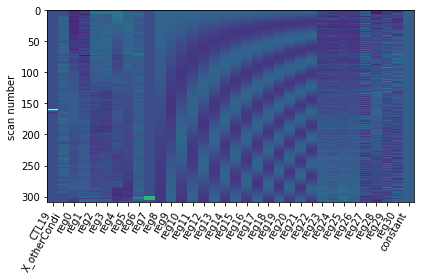

betas_sub122922_Trial065_CTL19.nii
066   Enc44   Index(['Enc44', 'X_otherCondi', 'reg0'], dtype='object')


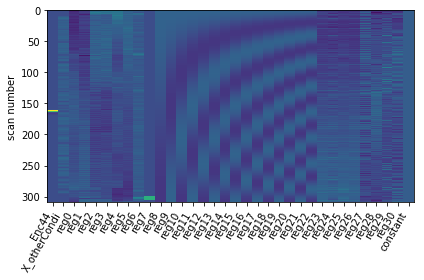

betas_sub122922_Trial066_Enc44.nii
067   CTL20   Index(['CTL20', 'X_otherCondi', 'reg0'], dtype='object')


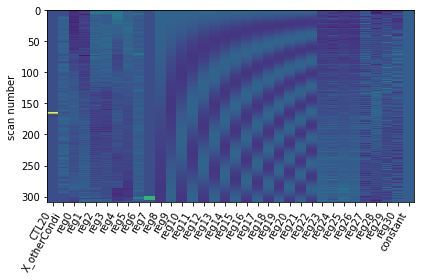

betas_sub122922_Trial067_CTL20.nii
068   CTL21   Index(['CTL21', 'X_otherCondi', 'reg0'], dtype='object')


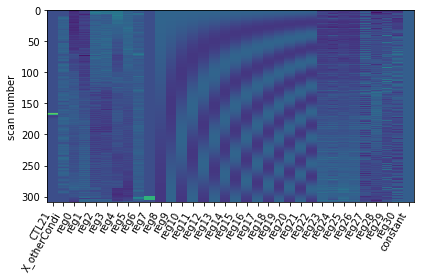

betas_sub122922_Trial068_CTL21.nii
069   Enc45   Index(['Enc45', 'X_otherCondi', 'reg0'], dtype='object')


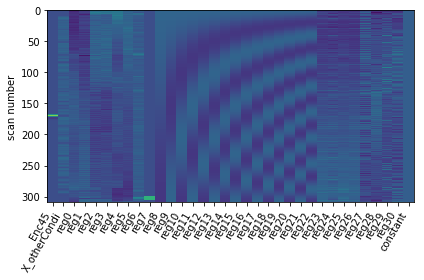

betas_sub122922_Trial069_Enc45.nii
070   CTL22   Index(['CTL22', 'X_otherCondi', 'reg0'], dtype='object')


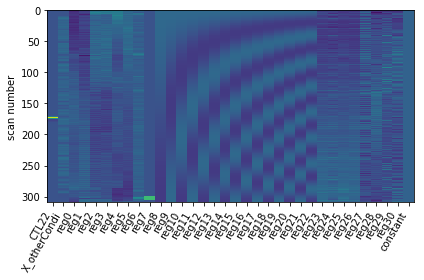

betas_sub122922_Trial070_CTL22.nii
071   Enc46   Index(['Enc46', 'X_otherCondi', 'reg0'], dtype='object')


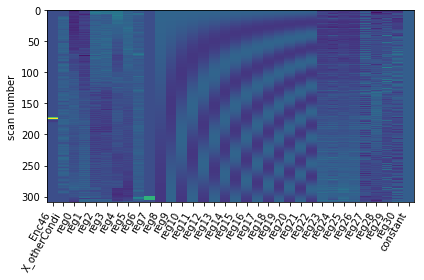

betas_sub122922_Trial071_Enc46.nii
072   Enc47   Index(['Enc47', 'X_otherCondi', 'reg0'], dtype='object')


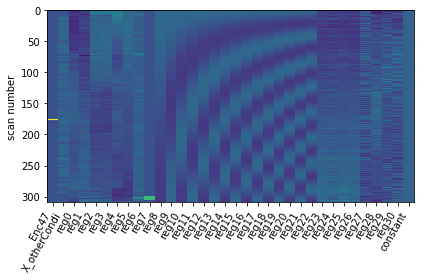

betas_sub122922_Trial072_Enc47.nii
073   Enc48   Index(['Enc48', 'X_otherCondi', 'reg0'], dtype='object')


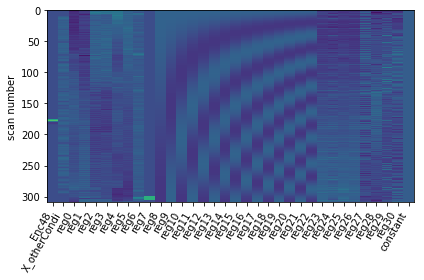

betas_sub122922_Trial073_Enc48.nii
074   Enc49   Index(['Enc49', 'X_otherCondi', 'reg0'], dtype='object')


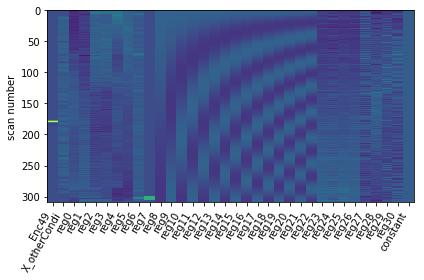

betas_sub122922_Trial074_Enc49.nii
075   Enc50   Index(['Enc50', 'X_otherCondi', 'reg0'], dtype='object')


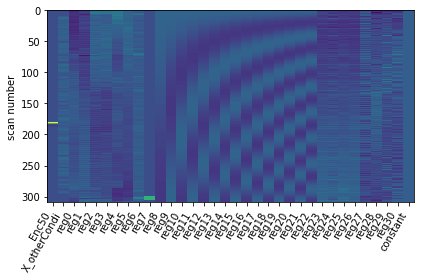

betas_sub122922_Trial075_Enc50.nii
076   Enc51   Index(['Enc51', 'X_otherCondi', 'reg0'], dtype='object')


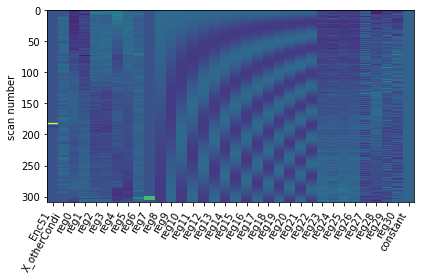

betas_sub122922_Trial076_Enc51.nii
077   Enc52   Index(['Enc52', 'X_otherCondi', 'reg0'], dtype='object')


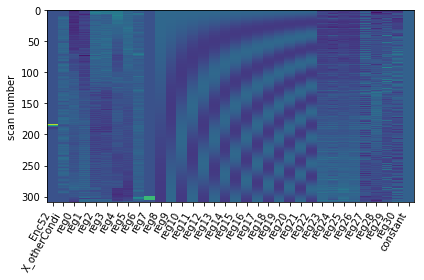

betas_sub122922_Trial077_Enc52.nii
078   CTL23   Index(['CTL23', 'X_otherCondi', 'reg0'], dtype='object')


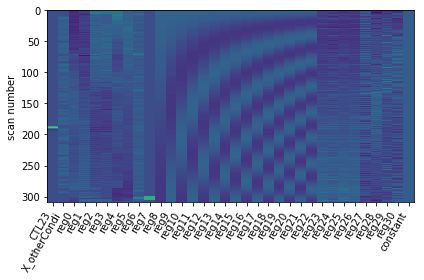

betas_sub122922_Trial078_CTL23.nii
079   Enc53   Index(['Enc53', 'X_otherCondi', 'reg0'], dtype='object')


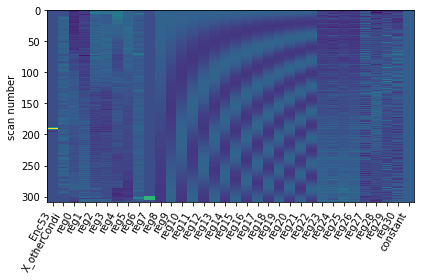

betas_sub122922_Trial079_Enc53.nii
080   CTL24   Index(['CTL24', 'X_otherCondi', 'reg0'], dtype='object')


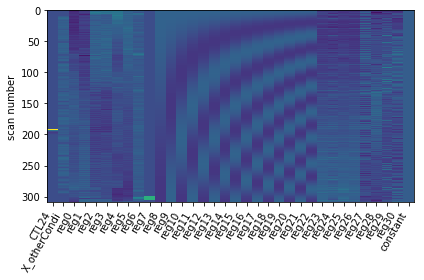

betas_sub122922_Trial080_CTL24.nii
081   Enc54   Index(['Enc54', 'X_otherCondi', 'reg0'], dtype='object')


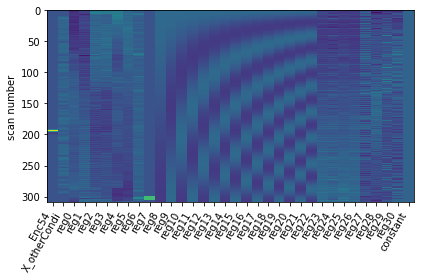

betas_sub122922_Trial081_Enc54.nii
082   Enc55   Index(['Enc55', 'X_otherCondi', 'reg0'], dtype='object')


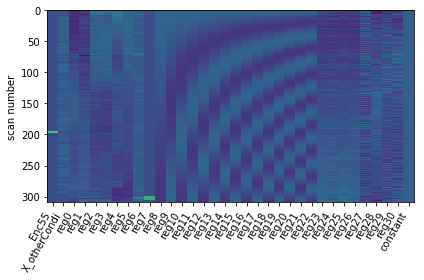

betas_sub122922_Trial082_Enc55.nii
083   Enc56   Index(['Enc56', 'X_otherCondi', 'reg0'], dtype='object')


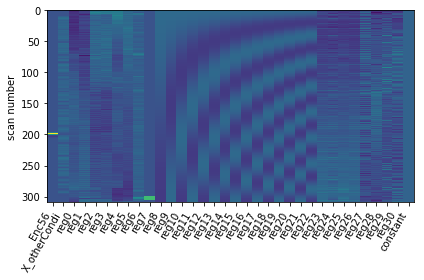

betas_sub122922_Trial083_Enc56.nii
084   Enc57   Index(['Enc57', 'X_otherCondi', 'reg0'], dtype='object')


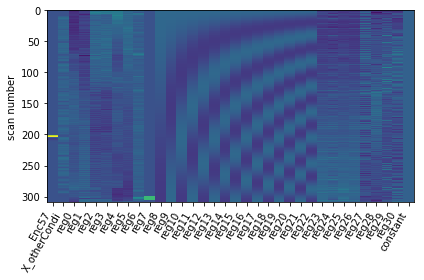

betas_sub122922_Trial084_Enc57.nii
085   CTL25   Index(['CTL25', 'X_otherCondi', 'reg0'], dtype='object')


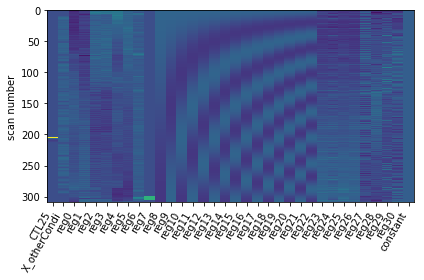

betas_sub122922_Trial085_CTL25.nii
086   Enc58   Index(['Enc58', 'X_otherCondi', 'reg0'], dtype='object')


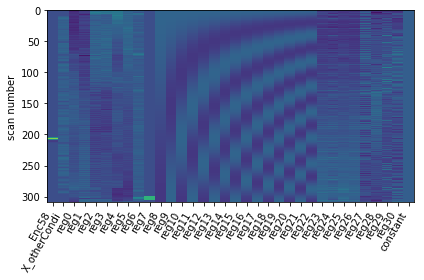

betas_sub122922_Trial086_Enc58.nii
087   Enc59   Index(['Enc59', 'X_otherCondi', 'reg0'], dtype='object')


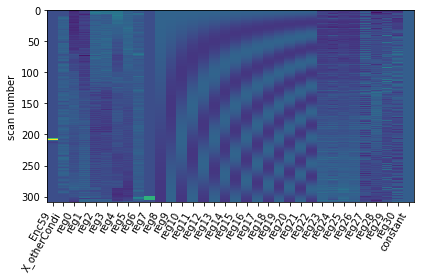

betas_sub122922_Trial087_Enc59.nii
088   Enc60   Index(['Enc60', 'X_otherCondi', 'reg0'], dtype='object')


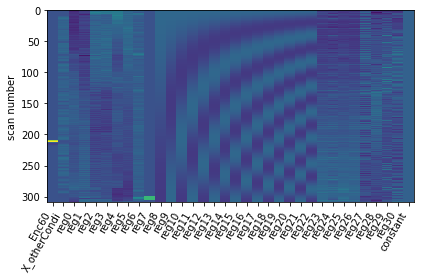

betas_sub122922_Trial088_Enc60.nii
089   CTL26   Index(['CTL26', 'X_otherCondi', 'reg0'], dtype='object')


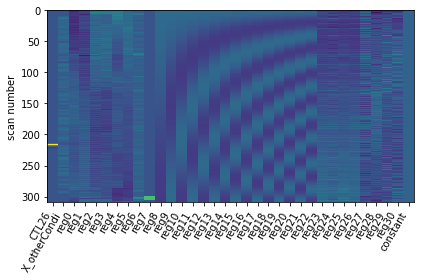

betas_sub122922_Trial089_CTL26.nii
090   CTL27   Index(['CTL27', 'X_otherCondi', 'reg0'], dtype='object')


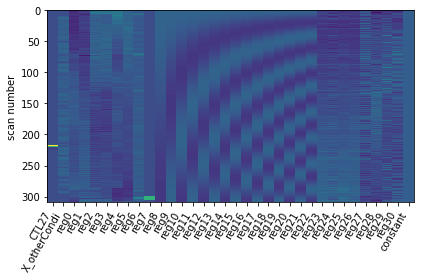

betas_sub122922_Trial090_CTL27.nii
091   CTL28   Index(['CTL28', 'X_otherCondi', 'reg0'], dtype='object')


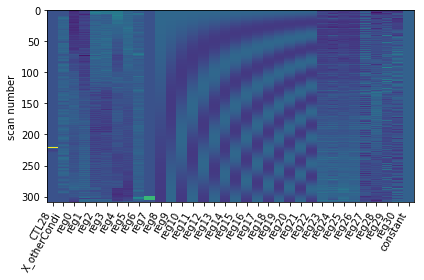

betas_sub122922_Trial091_CTL28.nii
092   Enc61   Index(['Enc61', 'X_otherCondi', 'reg0'], dtype='object')


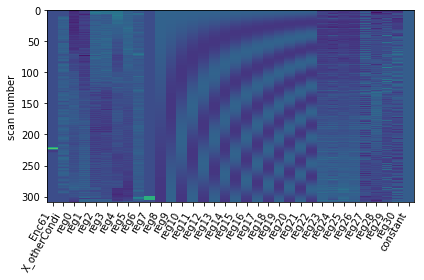

betas_sub122922_Trial092_Enc61.nii
093   Enc62   Index(['Enc62', 'X_otherCondi', 'reg0'], dtype='object')


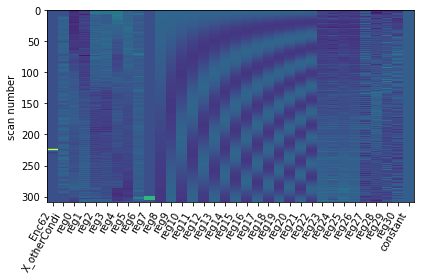

betas_sub122922_Trial093_Enc62.nii
094   CTL29   Index(['CTL29', 'X_otherCondi', 'reg0'], dtype='object')


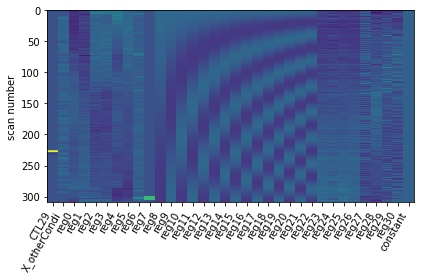

betas_sub122922_Trial094_CTL29.nii
095   Enc63   Index(['Enc63', 'X_otherCondi', 'reg0'], dtype='object')


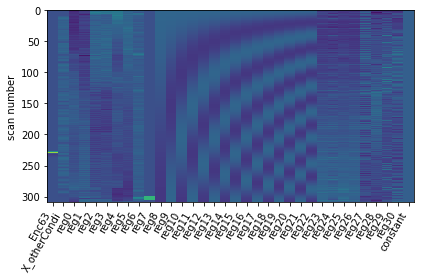

betas_sub122922_Trial095_Enc63.nii
096   Enc64   Index(['Enc64', 'X_otherCondi', 'reg0'], dtype='object')


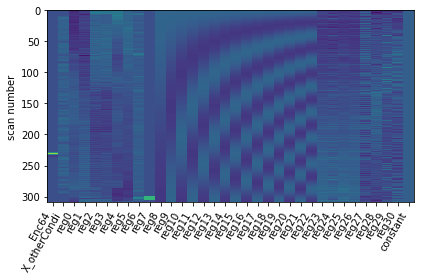

betas_sub122922_Trial096_Enc64.nii
097   CTL30   Index(['CTL30', 'X_otherCondi', 'reg0'], dtype='object')


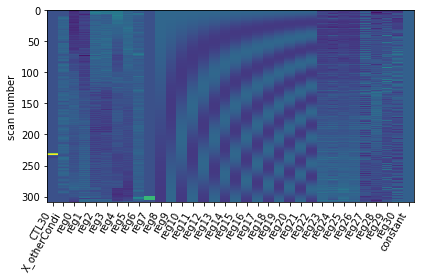

betas_sub122922_Trial097_CTL30.nii
098   Enc65   Index(['Enc65', 'X_otherCondi', 'reg0'], dtype='object')


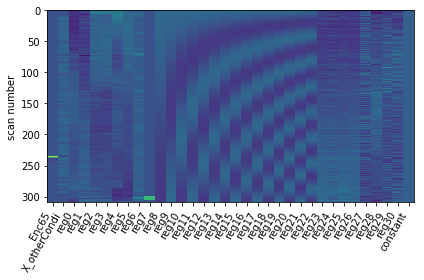

betas_sub122922_Trial098_Enc65.nii
099   Enc66   Index(['Enc66', 'X_otherCondi', 'reg0'], dtype='object')


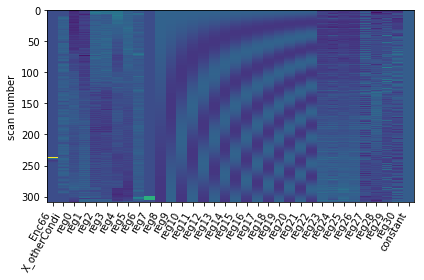

betas_sub122922_Trial099_Enc66.nii
100   CTL31   Index(['CTL31', 'X_otherCondi', 'reg0'], dtype='object')


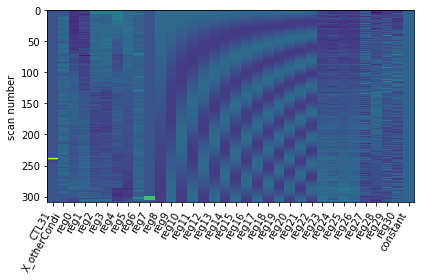

betas_sub122922_Trial100_CTL31.nii
101   CTL32   Index(['CTL32', 'X_otherCondi', 'reg0'], dtype='object')


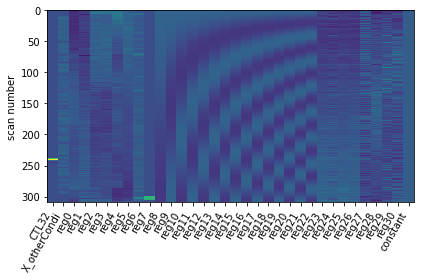

betas_sub122922_Trial101_CTL32.nii
102   Enc67   Index(['Enc67', 'X_otherCondi', 'reg0'], dtype='object')


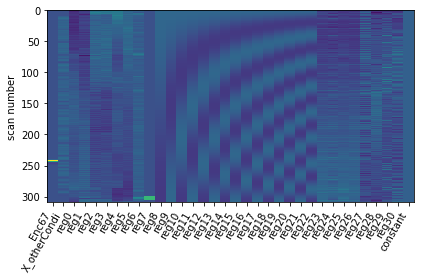

betas_sub122922_Trial102_Enc67.nii
103   Enc68   Index(['Enc68', 'X_otherCondi', 'reg0'], dtype='object')


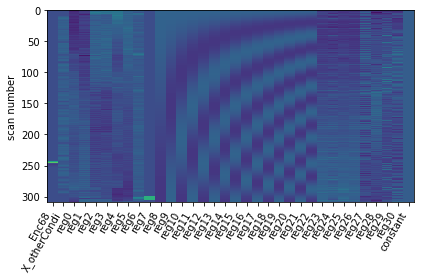

betas_sub122922_Trial103_Enc68.nii
104   CTL33   Index(['CTL33', 'X_otherCondi', 'reg0'], dtype='object')


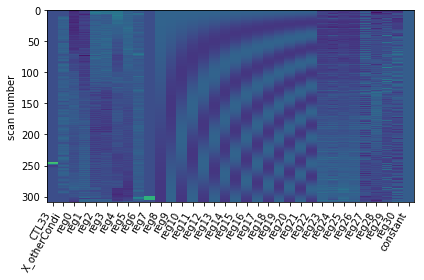

betas_sub122922_Trial104_CTL33.nii
105   CTL34   Index(['CTL34', 'X_otherCondi', 'reg0'], dtype='object')


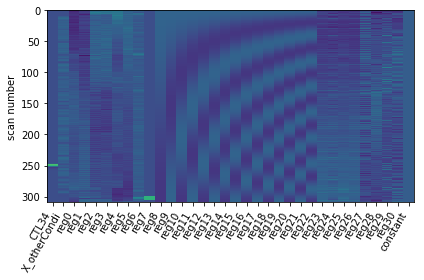

betas_sub122922_Trial105_CTL34.nii
106   Enc69   Index(['Enc69', 'X_otherCondi', 'reg0'], dtype='object')


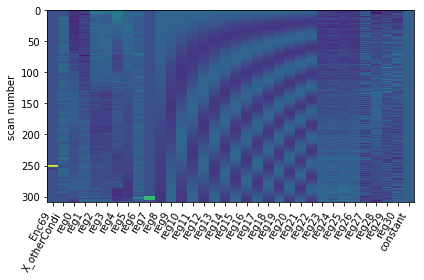

betas_sub122922_Trial106_Enc69.nii
107   Enc70   Index(['Enc70', 'X_otherCondi', 'reg0'], dtype='object')


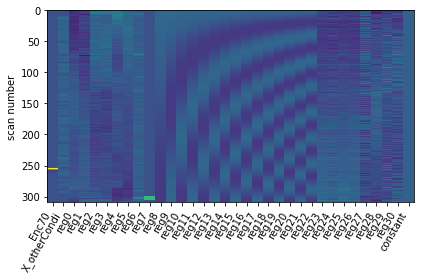

betas_sub122922_Trial107_Enc70.nii
108   CTL35   Index(['CTL35', 'X_otherCondi', 'reg0'], dtype='object')


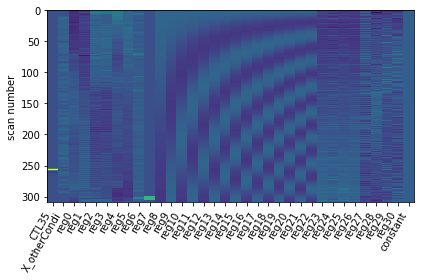

betas_sub122922_Trial108_CTL35.nii
109   CTL36   Index(['CTL36', 'X_otherCondi', 'reg0'], dtype='object')


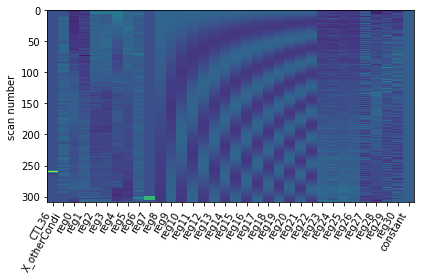

betas_sub122922_Trial109_CTL36.nii
110   Enc71   Index(['Enc71', 'X_otherCondi', 'reg0'], dtype='object')


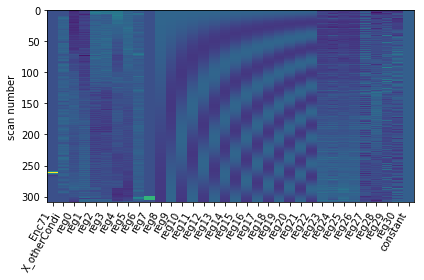

betas_sub122922_Trial110_Enc71.nii
111   Enc72   Index(['Enc72', 'X_otherCondi', 'reg0'], dtype='object')


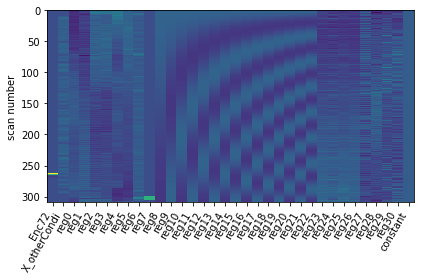

betas_sub122922_Trial111_Enc72.nii
112   CTL37   Index(['CTL37', 'X_otherCondi', 'reg0'], dtype='object')


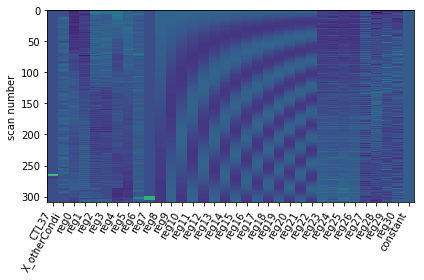

betas_sub122922_Trial112_CTL37.nii
113   CTL38   Index(['CTL38', 'X_otherCondi', 'reg0'], dtype='object')


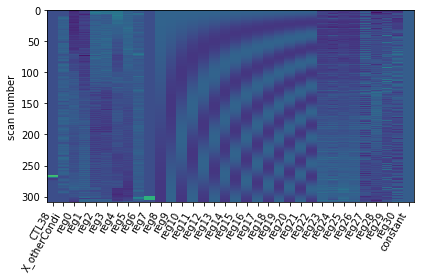

betas_sub122922_Trial113_CTL38.nii
114   Enc73   Index(['Enc73', 'X_otherCondi', 'reg0'], dtype='object')


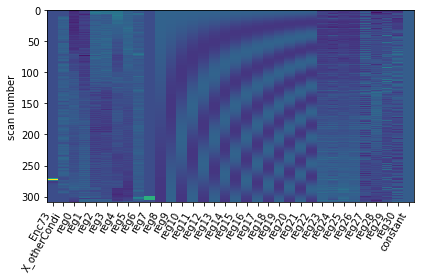

betas_sub122922_Trial114_Enc73.nii
115   Enc74   Index(['Enc74', 'X_otherCondi', 'reg0'], dtype='object')


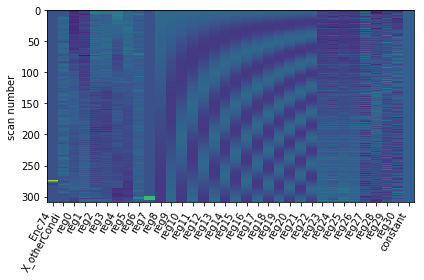

betas_sub122922_Trial115_Enc74.nii
116   CTL39   Index(['CTL39', 'X_otherCondi', 'reg0'], dtype='object')


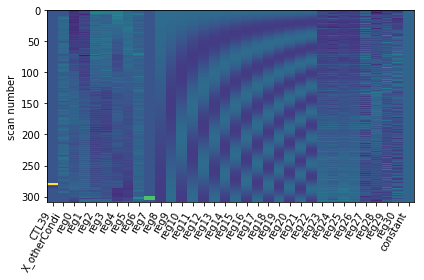

betas_sub122922_Trial116_CTL39.nii
117   Enc75   Index(['Enc75', 'X_otherCondi', 'reg0'], dtype='object')


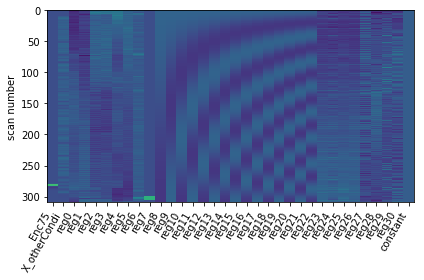

betas_sub122922_Trial117_Enc75.nii
118   Enc76   Index(['Enc76', 'X_otherCondi', 'reg0'], dtype='object')


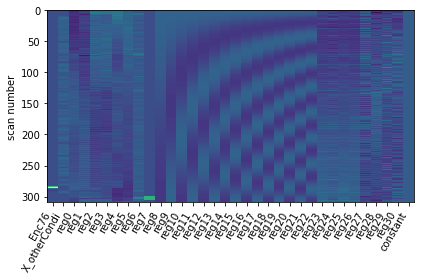

betas_sub122922_Trial118_Enc76.nii
119   Enc77   Index(['Enc77', 'X_otherCondi', 'reg0'], dtype='object')


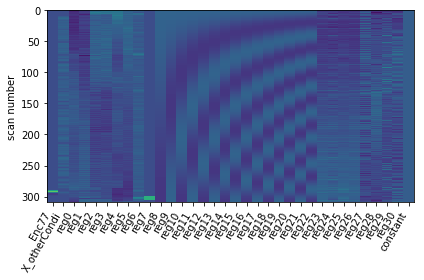

betas_sub122922_Trial119_Enc77.nii
120   Enc78   Index(['Enc78', 'X_otherCondi', 'reg0'], dtype='object')


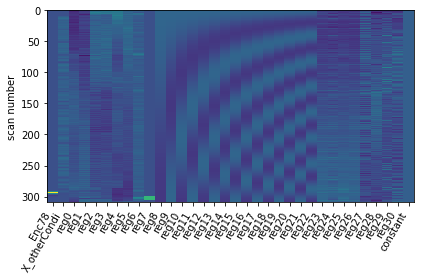

betas_sub122922_Trial120_Enc78.nii
(53, 64, 52, 117)


In [13]:
outBeta_dir_B = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/OneModelPerTrial_B'
all_betas_filelist_B = []
####

#Create a design matrix, first level model and beta map for each encoding and control trial 
for i in range (0, numTrials):

    #copy all_events dataframe to keep the original intact
    events = all_events.copy(deep = True)

    #Determine trial number and condition (encoding or control)
    tnum = events.iloc[i, 6]
    currentCondi = events.iloc[i, 3]
    tname = events.iloc[i, 2]
        
    #Version A: (2 conditions modelled separately)
    #modify trial_type column to model only the trial of interest 
    for j in events.index:
        if events.loc[j, 'trial_number'] != tnum:
            events.loc[j, 'trial_type']= 'X_otherCondi'
            #X for condition to remain in alphabetical order: trial of interest, X_CTL, X_Enc
    #verify: what determines the order of columns in design matrix?    

    #remove unecessary columns    
    cols = ['onset', 'duration', 'trial_type']
    events = events[cols]
    
    #create the model
    s_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                               hrf_model = hrf_model)    
    #Should data be standardized?

    #create the design matrices
    design = make_first_level_design_matrix(frame_times, events=events,
                                            drift_model=None, add_regs=confounds, 
                                            hrf_model=hrf_model)
    
    #fit model with design matrix
    s_model = s_model.fit(fmri_img, design_matrices = design)
    
    design_matrix = s_model.design_matrices_[0]
    
    #sanity check: print design matrices and corresponding parameter labels
    #plot outputed design matrix for visualization
    print(str(tnum), ' ', tname, ' ', design_matrix.columns[0:3])
    plot_design_matrix(design_matrix)
    plt.show()

    #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
    contrast_vec = np.repeat(0, design_matrix.shape[1])
    contrast_vec[0] = 1

    #compute the contrast's beta maps with the model.compute_contrast() method,
    #based on contrast provided. 
    #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
    b_map = s_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
    b_name = os.path.join(outBeta_dir_B, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
    #export b_map .nii image in output directory
    nibabel.save(b_map, b_name)
    print(os.path.basename(b_name))
    all_betas_filelist_B.append(b_name)
    
alltrials_betas_B = nibabel.funcs.concat_images(images=all_betas_filelist_B, check_affines=True, axis=None)
print(alltrials_betas_B.shape)
nibabel.save(alltrials_betas_B, os.path.join(outBeta_dir_B, 'concat_all_betas_sub'+str(id)+'.nii'))



    onset  duration trial_type
0  25.027     3.009        Enc
1  28.537     3.009        CTL
2  32.048     3.009        Enc
3  39.553     3.009        Enc
4  44.552     3.009        CTL


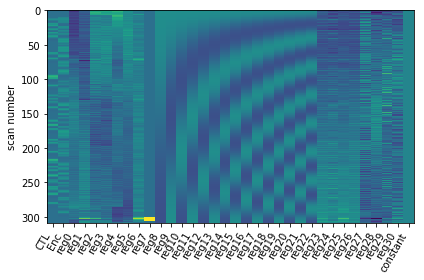

Index(['CTL', 'Enc', 'reg0', 'reg1', 'reg2'], dtype='object')
betas_sub122922_ctl.nii
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_enc.nii
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_enc_minus_ctl.nii
[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]


In [29]:
outBeta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts'

#Model 1: encoding vs control conditions
events1 = all_events.copy(deep = True)
cols = ['onset', 'duration', 'condition']
events1 = events1[cols]
events1.rename(columns={'condition':'trial_type'}, inplace=True)

print(events1.head())

#create the model
model1 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design1 = make_first_level_design_matrix(frame_times, events=events1,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model1 = model1.fit(fmri_img, design_matrices = design1)    

design_matrix1 = model1.design_matrices_[0]    
plot_design_matrix(design_matrix1)
plt.show()
print(design_matrix1.columns[0:5])

#Condition order: control, encoding (alphabetical)

#contrast 1.1: control condition
ctl_vec = np.repeat(0, design_matrix1.shape[1])
ctl_vec[0] = 1
b11_map = model1.compute_contrast(ctl_vec, output_type='effect_size') #"effect_size" for betas
b11_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ctl.nii')
nibabel.save(b11_map, b11_name)
print(os.path.basename(b11_name))
print(ctl_vec)

#contrast 1.2: encoding condition
enc_vec = np.repeat(0, design_matrix1.shape[1])
enc_vec[1] = 1
b12_map = model1.compute_contrast(enc_vec, output_type='effect_size') #"effect_size" for betas
b12_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc.nii')
nibabel.save(b12_map, b12_name)
print(os.path.basename(b12_name))
print(enc_vec)

#contrast 1.3: encoding minus control 
encMinCtl_vec = np.repeat(0, design_matrix1.shape[1])
encMinCtl_vec[1] = 1
encMinCtl_vec[0] = -1
b13_map = model1.compute_contrast(encMinCtl_vec, output_type='effect_size') #"effect_size" for betas
b13_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc_minus_ctl.nii')
nibabel.save(b13_map, b13_name)
print(os.path.basename(b13_name))
print(encMinCtl_vec)


     onset  duration trial_type
0   25.027     3.009        hit
1   28.537     3.009    control
2   32.048     3.009        hit
3   39.553     3.009        hit
4   44.552     3.009    control
5   51.054     3.009    control
6   55.551     3.009     missed
7   61.051     3.009        hit
8   65.063     3.009    control
9   71.064     3.009        hit
10  78.068     3.009    control
11  81.579     3.008     missed
12  87.078     3.009    control
13  92.578     3.009    control
14  99.081     3.009     missed


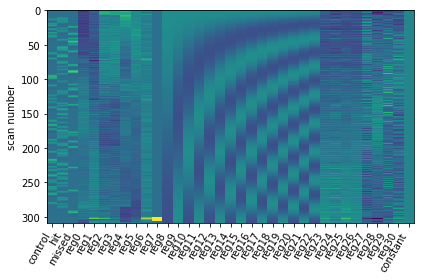

Index(['control', 'hit', 'missed', 'reg0', 'reg1'], dtype='object')
betas_sub122922_miss.nii
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_hit.nii
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_hit_minus_miss.nii
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_hit_minus_ctl.nii
[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_miss_minus_ctl.nii
[-1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]


In [30]:
#Model 2: missed vs hit encoding trials
events2 = all_events.copy(deep = True)
cols2 = ['onset', 'duration', 'ctl_miss_hit']
events2 = events2[cols2]
events2.rename(columns={'ctl_miss_hit':'trial_type'}, inplace=True)

print(events2.iloc[0:15, :])

#create the model
model2 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design2 = make_first_level_design_matrix(frame_times, events=events2,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model2 = model2.fit(fmri_img, design_matrices = design2)    

design_matrix2 = model2.design_matrices_[0]    
plot_design_matrix(design_matrix2)
plt.show()
print(design_matrix2.columns[0:5])

##Condition order: control, hit, missed (alphabetical)

#contrast 2.1: miss 
miss_vec = np.repeat(0, design_matrix2.shape[1])
miss_vec[2] = 1
b21_map = model2.compute_contrast(miss_vec, output_type='effect_size') #"effect_size" for betas
b21_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss.nii')
nibabel.save(b21_map, b21_name)
print(os.path.basename(b21_name))
print(miss_vec)

#contrast 2.2: hit 
hit_vec = np.repeat(0, design_matrix2.shape[1])
hit_vec[1] = 1
b22_map = model2.compute_contrast(hit_vec, output_type='effect_size') #"effect_size" for betas
b22_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit.nii')
nibabel.save(b22_map, b22_name)
print(os.path.basename(b22_name))
print(hit_vec)

#contrast 2.3: hit minus miss
hit_min_miss_vec = np.repeat(0, design_matrix2.shape[1])
hit_min_miss_vec[1] = 1
hit_min_miss_vec[2] = -1
b23_map = model2.compute_contrast(hit_min_miss_vec, output_type='effect_size') #"effect_size" for betas
b23_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_miss.nii')
nibabel.save(b23_map, b23_name)
print(os.path.basename(b23_name))
print(hit_min_miss_vec)

#contrast 2.4: hit minus control
hit_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
hit_min_ctl_vec[1] = 1
hit_min_ctl_vec[0] = -1
b24_map = model2.compute_contrast(hit_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
b24_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_ctl.nii')
nibabel.save(b24_map, b24_name)
print(os.path.basename(b24_name))
print(hit_min_ctl_vec)

#contrast 2.5: miss minus control 
miss_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
miss_min_ctl_vec[2] = 1
miss_min_ctl_vec[0] = -1
b25_map = model2.compute_contrast(miss_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
b25_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss_minus_ctl.nii')
nibabel.save(b25_map, b25_name)
print(os.path.basename(b25_name))
print(miss_min_ctl_vec)


     onset  duration     trial_type
0   25.027     3.009  correctsource
1   28.537     3.009        control
2   32.048     3.009    wrongsource
3   39.553     3.009    wrongsource
4   44.552     3.009        control
5   51.054     3.009        control
6   55.551     3.009         missed
7   61.051     3.009    wrongsource
8   65.063     3.009        control
9   71.064     3.009  correctsource
10  78.068     3.009        control
11  81.579     3.008         missed
12  87.078     3.009        control
13  92.578     3.009        control
14  99.081     3.009         missed


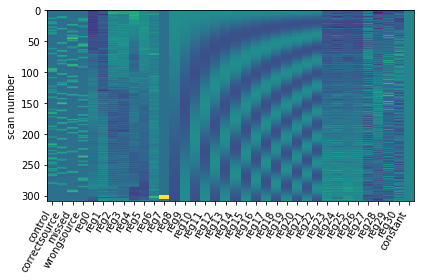

Index(['control', 'correctsource', 'missed', 'wrongsource', 'reg0'], dtype='object')
betas_sub122922_ws.nii
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_cs.nii
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
betas_sub122922_cs_minus_ws.nii
[ 0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_cs_minus_miss.nii
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_ws_minus_miss.nii
[ 0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_cs_minus_ctl.nii
[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
betas_sub122922_ws_minus_ctl.nii
[-1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [31]:
#Model 3: correct source vs wrong source encoding trials
events3 = all_events.copy(deep = True)
cols3 = ['onset', 'duration', 'ctl_miss_ws_cs']
events3 = events3[cols3]
events3.rename(columns={'ctl_miss_ws_cs':'trial_type'}, inplace=True)

print(events3.iloc[0:15, :])

#create the model
model3 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design3 = make_first_level_design_matrix(frame_times, events=events3,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model3 = model3.fit(fmri_img, design_matrices = design3)    

design_matrix3 = model3.design_matrices_[0]    
plot_design_matrix(design_matrix3)
plt.show()
print(design_matrix3.columns[0:5])

##Condition order: control, correct source, missed, wrong source (alphabetical)

#contrast 3.1: wrong source 
ws_vec = np.repeat(0, design_matrix3.shape[1])
ws_vec[3] = 1
b31_map = model3.compute_contrast(ws_vec, output_type='effect_size') #"effect_size" for betas
b31_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws.nii')
nibabel.save(b31_map, b31_name)
print(os.path.basename(b31_name))
print(ws_vec)

#contrast 3.2: correct source
cs_vec = np.repeat(0, design_matrix3.shape[1])
cs_vec[1] = 1
b32_map = model3.compute_contrast(cs_vec, output_type='effect_size') #"effect_size" for betas
b32_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs.nii')
nibabel.save(b32_map, b32_name)
print(os.path.basename(b32_name))
print(cs_vec)

#contrast 3.3: correct source minus wrong source
cs_minus_ws_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_ws_vec[1] = 1
cs_minus_ws_vec[3] = -1
b33_map = model3.compute_contrast(cs_minus_ws_vec, output_type='effect_size') #"effect_size" for betas
b33_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ws.nii')
nibabel.save(b33_map, b33_name)
print(os.path.basename(b33_name))
print(cs_minus_ws_vec)

#contrast 3.4: correct source minus miss
cs_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_miss_vec[1] = 1
cs_minus_miss_vec[2] = -1
b34_map = model3.compute_contrast(cs_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
b34_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_miss.nii')
nibabel.save(b34_map, b34_name)
print(os.path.basename(b34_name))
print(cs_minus_miss_vec)

#contrast 3.5: wrong source minus miss
ws_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
ws_minus_miss_vec[3] = 1
ws_minus_miss_vec[2] = -1
b35_map = model3.compute_contrast(ws_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
b35_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_miss.nii')
nibabel.save(b35_map, b35_name)
print(os.path.basename(b35_name))
print(ws_minus_miss_vec)

#contrast 3.6: correct source minus control
cs_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_ctl_vec[1] = 1
cs_minus_ctl_vec[0] = -1
b36_map = model3.compute_contrast(cs_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
b36_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ctl.nii')
nibabel.save(b36_map, b36_name)
print(os.path.basename(b36_name))
print(cs_minus_ctl_vec)

#contrast 3.7: wrong source minus control
ws_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
ws_minus_ctl_vec[3] = 1
ws_minus_ctl_vec[0] = -1
b37_map = model3.compute_contrast(ws_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
b37_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_ctl.nii')
nibabel.save(b37_map, b37_name)
print(os.path.basename(b37_name))
print(ws_minus_ctl_vec)


/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws_minus_miss.nii


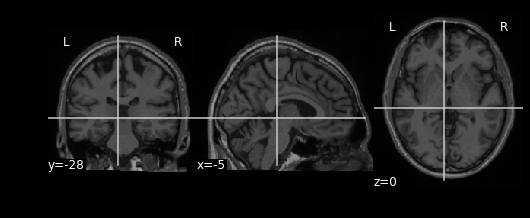

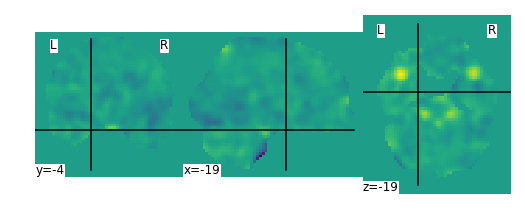

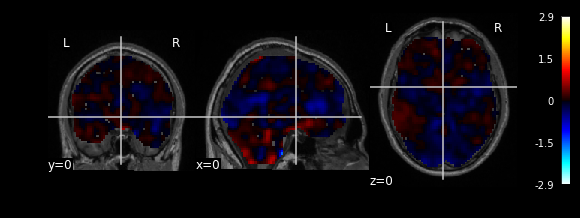

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_ws.nii


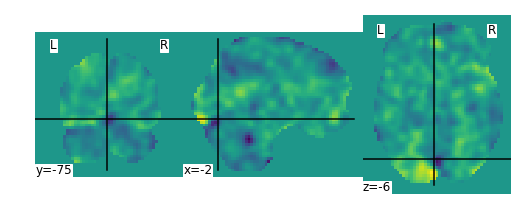

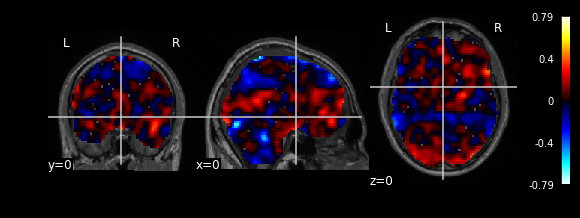

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit_minus_miss.nii


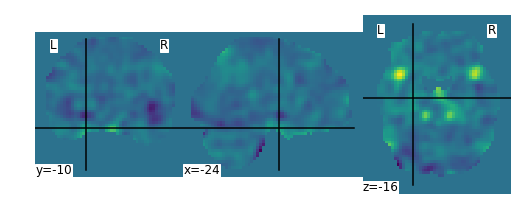

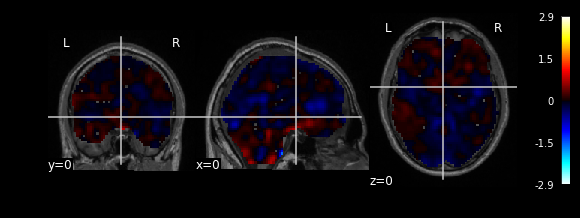

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws_minus_ctl.nii


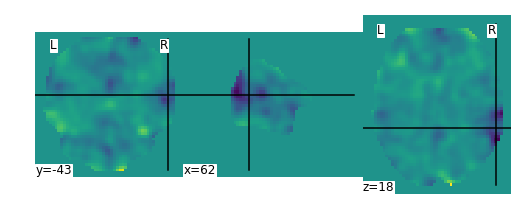

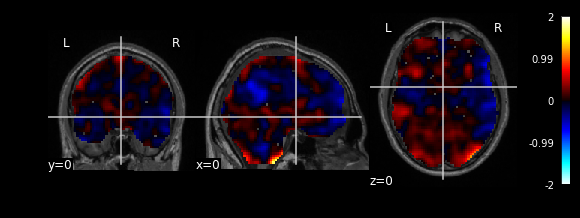

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ctl.nii


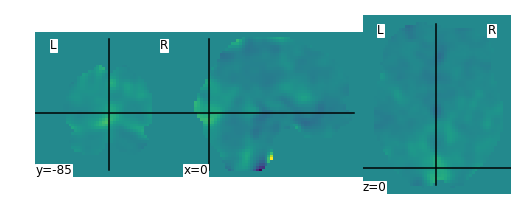

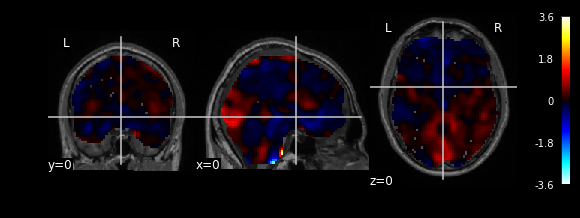

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_enc.nii


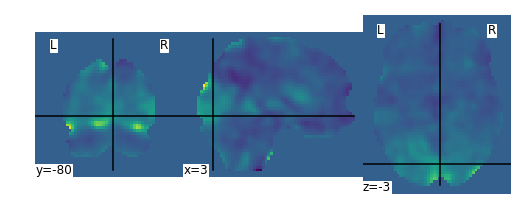

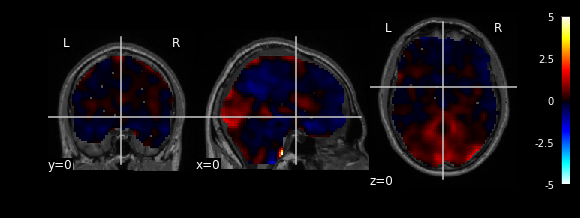

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_miss.nii


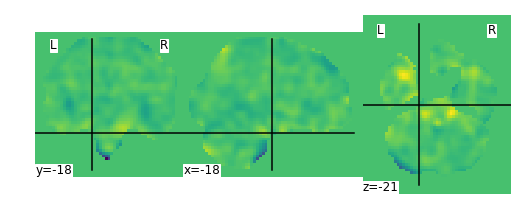

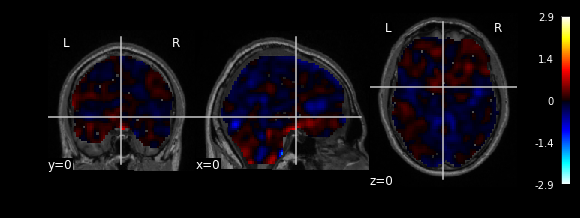

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit_minus_ctl.nii


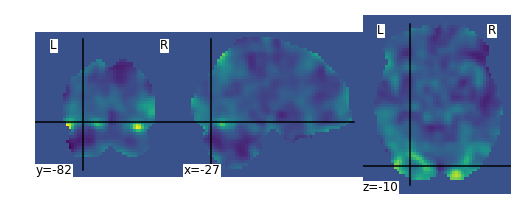

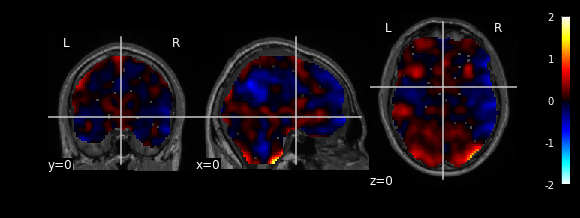

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_enc_minus_ctl.nii


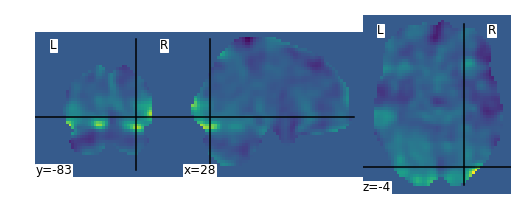

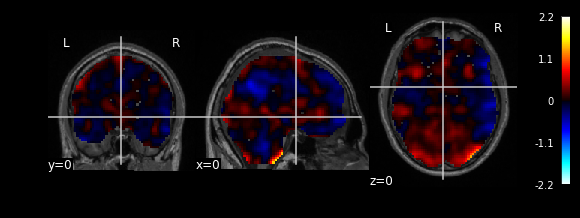

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws.nii


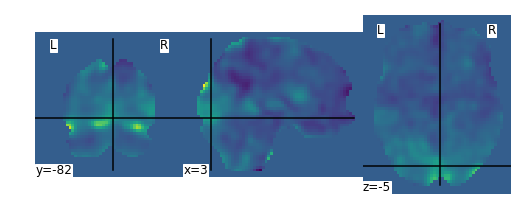

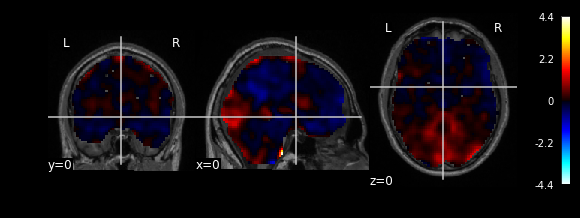

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit.nii


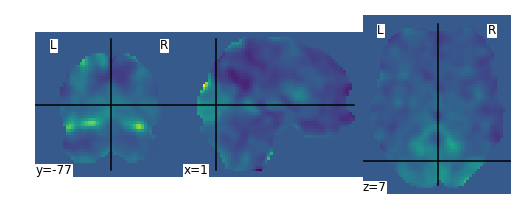

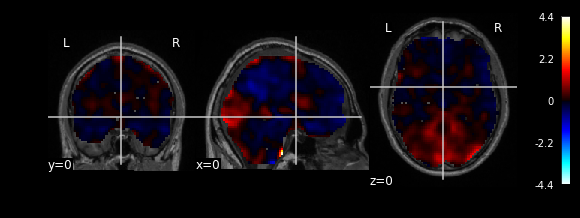

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs.nii


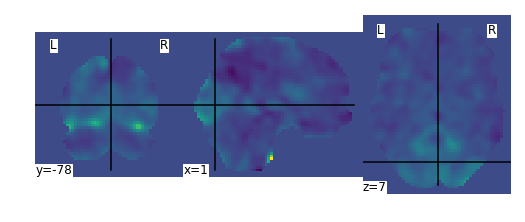

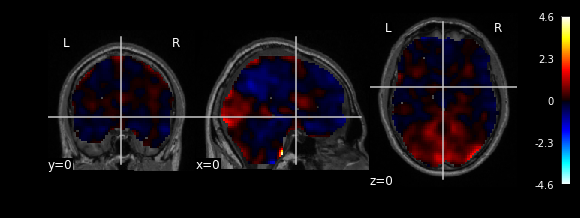

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_ctl.nii


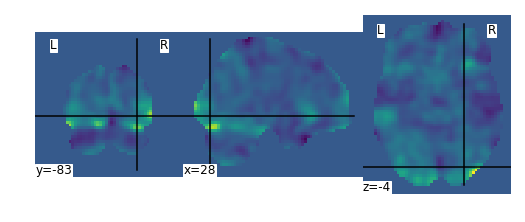

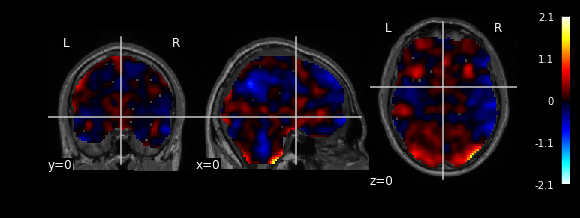

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_miss.nii


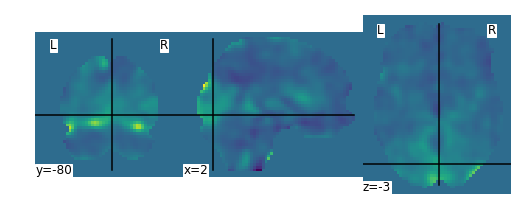

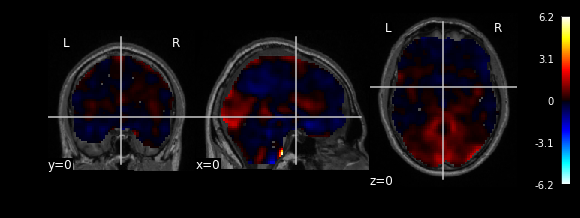

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_miss_minus_ctl.nii


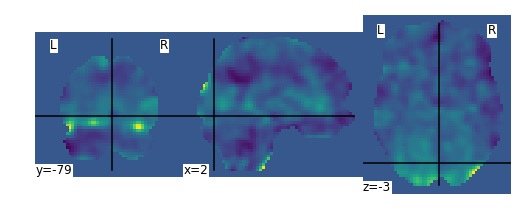

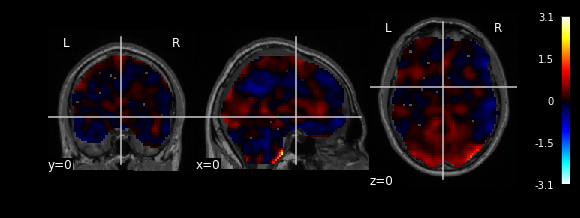

In [39]:
#Visualize beta maps

#plotting brain images in nilearn:
#http://nilearn.github.io/plotting/index.html

#define directory where subject's functional mask and anatomical scan reside
anat_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922'
#subject's anatomical scan
anat = nibabel.load(os.path.join(anat_dir, 'anat_sub122922_nuc_stereonl.nii'))
plot_anat(anat)

beta_list = glob.glob(os.path.join(outBeta_dir, '*.nii'))

for beta in beta_list:
    print(beta)
    plot_img(beta)
    plot_stat_map(stat_map_img=beta, bg_img=anat, cut_coords=(0, 0, 0), threshold=0.001, colorbar=True)
    show()
